<a href="https://colab.research.google.com/github/oorange-ocean/thermx-data/blob/main/%E7%81%AB%E7%94%B5%E6%95%B0%E6%8D%AE3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 环境设置与库导入

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from google.colab import drive
from scipy.stats import skew, variation
from scipy.signal import find_peaks, savgol_filter
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
import torch
import sys
from tqdm import tqdm

# 挂载 Google Drive
drive.mount('/content/drive')

# 定义文件路径
DATA_PATH = '/content/drive/My Drive/蚌埠电厂.csv'
SAVE_PATH = '/content/drive/My Drive/cleaned_results.csv'
STEADY_SAVE_PATH = '/content/drive/My Drive/steady_state_data.csv'
FEATURE_SAVE_PATH = '/content/drive/My Drive/ts2vec_features.csv'
CLUSTER_SAVE_PATH = '/content/drive/My Drive/clustering_data.csv'

# 设置中文字体
!wget -q -O simhei.ttf 'https://github.com/StellarCN/scp_zh/raw/master/fonts/SimHei.ttf'
matplotlib.font_manager.fontManager.addfont('simhei.ttf')
plt.rcParams['font.family'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False

# 安装 TS2Vec 依赖
!pip install torch numpy pandas scipy tqdm -q
!git clone https://github.com/zhihanyue/ts2vec.git -q
sys.path.append('/content/ts2vec')
from ts2vec import TS2Vec

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
fatal: destination path 'ts2vec' already exists and is not an empty directory.


## 数据加载与预览

In [ ]:
df = pd.read_csv(DATA_PATH, encoding='gbk')
print("数据预览：\n", df.head())
print("\n数据信息：")
df.info()

数据预览：
                时间    机组负荷  汽轮机热耗率q  修正后热耗率q    修正系数   高压缸效率   中压缸效率  低压缸排汽压力  \
0  2023/4/25 0:00  474.30   7693.0   7706.1  0.9983  86.078  96.115     4.06   
1  2023/4/25 0:00  476.03   7684.0   7699.4  0.9980  86.361  95.944     4.06   
2  2023/4/25 0:00  472.13   7687.2   7699.5  0.9984  86.173  96.010     4.08   
3  2023/4/25 0:01  470.13   7710.7   7723.8  0.9983  86.236  95.807     4.08   
4  2023/4/25 0:01  469.86   7909.1   7919.4  0.9987  86.802  95.720     4.08   

   主给水流量c     Dms  ...  省煤器进口给水压力  省煤器进口给水温度  给泵出口母管压力   锅炉效率  除氧器下水温度1  \
0  1287.2  1284.2  ...      24.63     263.67     24.83  92.70    165.92   
1  1290.2  1287.2  ...      24.58     263.69     24.78  92.71    166.08   
2  1280.1  1277.2  ...      24.54     263.70     24.74  92.71    166.08   
3  1278.3  1275.4  ...      24.49     263.70     24.69  92.71    166.24   
4  1309.0  1306.0  ...      24.43     263.43     24.64  92.72    166.25   

   除氧器下水温度2  除氧器进水温度  除氧器进汽温度  高压缸排汽压力  高压缸排汽温度  
0    165.47

## 异常值检测与清理


=== 处理列 '机组负荷' ===

检查列 '机组负荷' 的数据状态：
列 '机组负荷' 分布分析：
- 有效数据量：122343
- 最小值：290.06, 最大值：637.00
- 低值区 (<5.0) 比例：0.00%
- 偏度：-0.13, 峰值数量：0
推荐方法：IQR 方法
列 '机组负荷' 无异常值

=== 处理列 '汽轮机热耗率q' ===

检查列 '汽轮机热耗率q' 的数据状态：
列 '汽轮机热耗率q' 分布分析：
- 有效数据量：122343
- 最小值：6017.40, 最大值：10437.80
- 低值区 (<5.0) 比例：0.00%
- 偏度：1.14, 峰值数量：0
推荐方法：百分位法
检测到 2448 个异常值，占比 2.00%
异常值样本 - 最小值端： [6017.4, 6054.7, 6074.6, 6145.4, 6153.2]
最大值端： [10437.8, 10436.5, 10395.6, 10386.4, 10376.0]


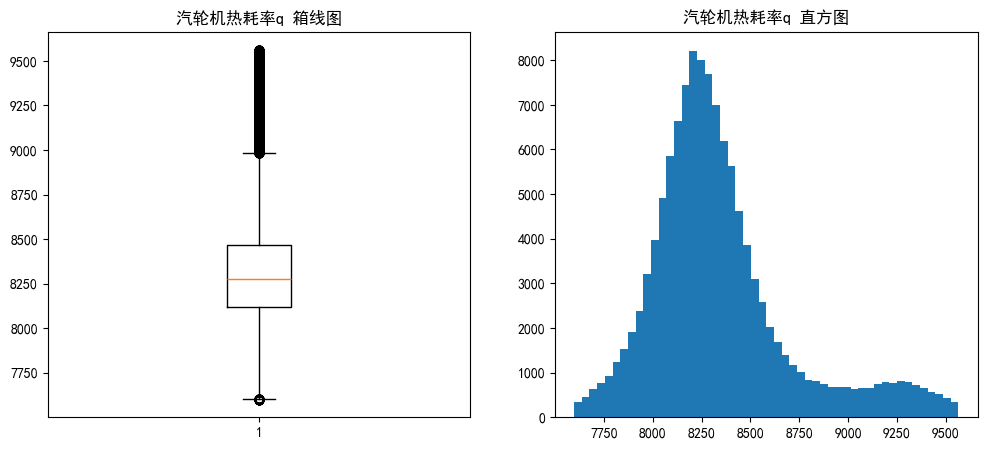


=== 处理列 '修正后热耗率q' ===

检查列 '修正后热耗率q' 的数据状态：
列 '修正后热耗率q' 分布分析：
- 有效数据量：122343
- 最小值：5976.20, 最大值：10588.60
- 低值区 (<5.0) 比例：0.00%
- 偏度：1.25, 峰值数量：0
推荐方法：百分位法
检测到 2448 个异常值，占比 2.00%
异常值样本 - 最小值端： [5976.2, 6012.6, 6030.0, 6097.2, 6101.3]
最大值端： [10588.6, 10568.6, 10536.8, 10512.7, 10490.6]


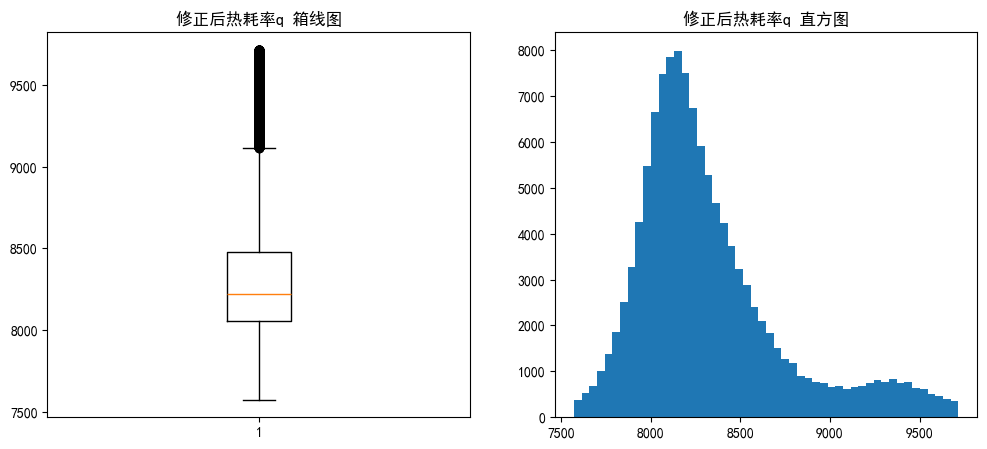


=== 处理列 '修正系数' ===

检查列 '修正系数' 的数据状态：
列 '修正系数' 分布分析：
- 有效数据量：122343
- 最小值：0.96, 最大值：1.05
- 低值区 (<5.0) 比例：100.00%
- 偏度：0.24, 峰值数量：9
推荐方法：多峰处理
列 '修正系数' 无异常值

=== 处理列 '高压缸效率' ===

检查列 '高压缸效率' 的数据状态：
列 '高压缸效率' 分布分析：
- 有效数据量：122343
- 最小值：66.81, 最大值：97.52
- 低值区 (<5.0) 比例：0.00%
- 偏度：-0.08, 峰值数量：1
推荐方法：IQR 方法
检测到 1192 个异常值，占比 0.97%
异常值样本 - 最小值端： [66.809, 67.293, 67.33, 67.482, 68.217]
最大值端： [97.523, 97.2, 97.115, 97.025, 97.024]


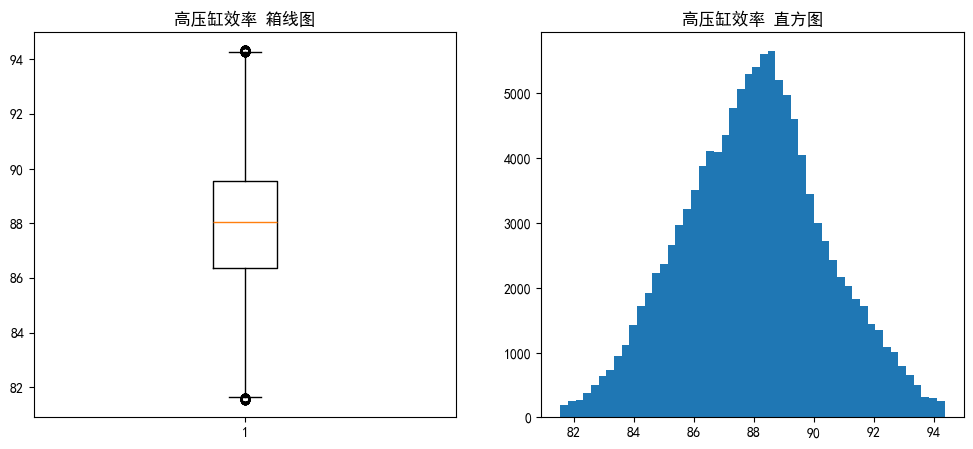


=== 处理列 '中压缸效率' ===

检查列 '中压缸效率' 的数据状态：
列 '中压缸效率' 分布分析：
- 有效数据量：122343
- 最小值：89.09, 最大值：98.82
- 低值区 (<5.0) 比例：0.00%
- 偏度：-0.06, 峰值数量：1
推荐方法：IQR 方法
检测到 3979 个异常值，占比 3.25%
异常值样本 - 最小值端： [89.093, 89.274, 89.361, 89.549, 89.715]
最大值端： [98.817, 98.803, 98.786, 98.772, 98.728]


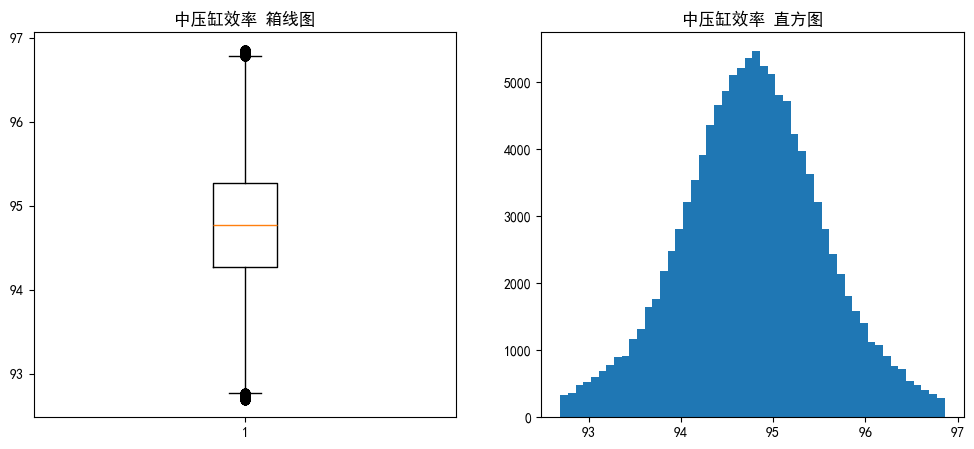


=== 处理列 '低压缸排汽压力' ===

检查列 '低压缸排汽压力' 的数据状态：
列 '低压缸排汽压力' 分布分析：
- 有效数据量：122343
- 最小值：3.28, 最大值：7.78
- 低值区 (<5.0) 比例：40.34%
- 偏度：0.29, 峰值数量：3
推荐方法：多峰处理
列 '低压缸排汽压力' 无异常值

=== 处理列 '主给水流量c' ===

检查列 '主给水流量c' 的数据状态：
列 '主给水流量c' 分布分析：
- 有效数据量：122343
- 最小值：757.60, 最大值：2033.60
- 低值区 (<5.0) 比例：0.00%
- 偏度：0.04, 峰值数量：0
推荐方法：IQR 方法
列 '主给水流量c' 无异常值

=== 处理列 'Dms' ===

检查列 'Dms' 的数据状态：
列 'Dms' 分布分析：
- 有效数据量：122343
- 最小值：755.90, 最大值：2028.90
- 低值区 (<5.0) 比例：0.00%
- 偏度：0.04, 峰值数量：0
推荐方法：IQR 方法
列 'Dms' 无异常值

=== 处理列 'Dgp' ===

检查列 'Dgp' 的数据状态：
列 'Dgp' 分布分析：
- 有效数据量：122343
- 最小值：640.60, 最大值：1631.10
- 低值区 (<5.0) 比例：0.00%
- 偏度：0.02, 峰值数量：0
推荐方法：IQR 方法
列 'Dgp' 无异常值

=== 处理列 'Drh' ===

检查列 'Drh' 的数据状态：
列 'Drh' 分布分析：
- 有效数据量：122343
- 最小值：663.40, 最大值：1629.70
- 低值区 (<5.0) 比例：0.00%
- 偏度：0.00, 峰值数量：0
推荐方法：IQR 方法
列 'Drh' 无异常值

=== 处理列 'Dmfs' ===

检查列 'Dmfs' 的数据状态：
列 'Dmfs' 分布分析：
- 有效数据量：122343
- 最小值：2.60, 最大值：5.70
- 低值区 (<5.0) 比例：99.44%
- 偏度：-0.25, 峰值数量：13
推荐方法：多峰处理
检测到 130 个异常值，占比 0.11%
异常值样本 - 最小值端： [5.2, 5.2, 5.2

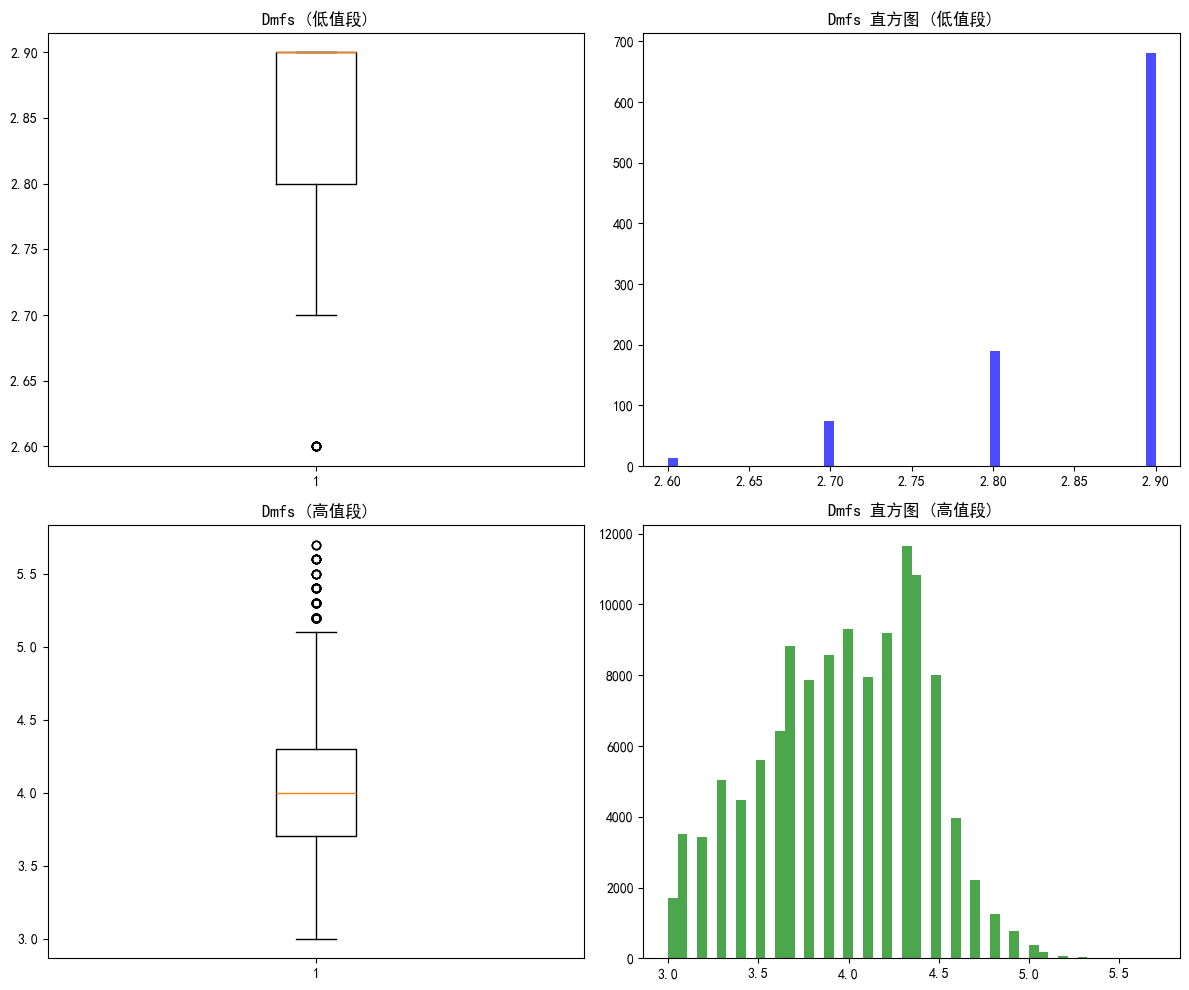


=== 处理列 'D1' ===

检查列 'D1' 的数据状态：
列 'D1' 分布分析：
- 有效数据量：122343
- 最小值：40.00, 最大值：473.40
- 低值区 (<5.0) 比例：0.00%
- 偏度：3.28, 峰值数量：0
推荐方法：百分位法
检测到 2381 个异常值，占比 1.95%
异常值样本 - 最小值端： [40.0, 40.4, 40.5, 40.6, 40.8]
最大值端： [473.4, 460.5, 455.9, 454.9, 453.4]


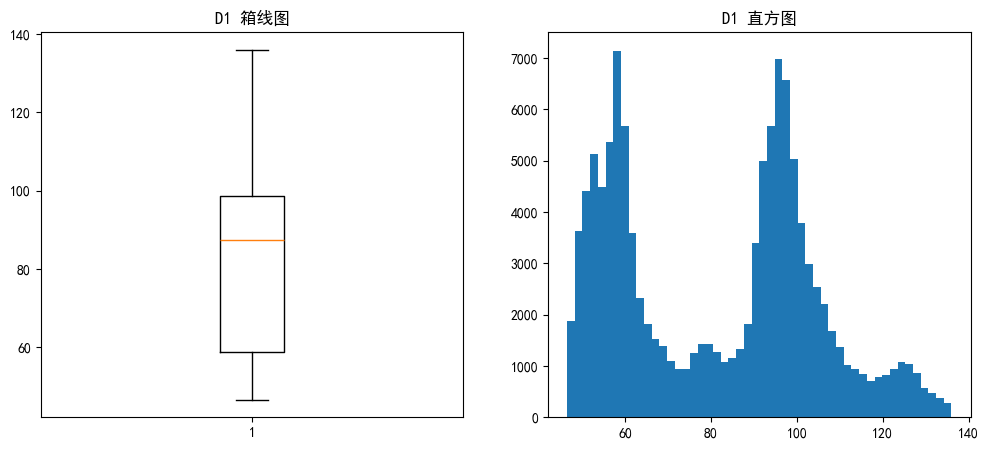


=== 处理列 'D2' ===

检查列 'D2' 的数据状态：
列 'D2' 分布分析：
- 有效数据量：122343
- 最小值：-354.50, 最大值：184.10
- 低值区 (<5.0) 比例：0.30%
- 偏度：-3.26, 峰值数量：0
推荐方法：百分位法
检测到 2405 个异常值，占比 1.97%
异常值样本 - 最小值端： [-354.5, -341.9, -339.1, -337.3, -336.8]
最大值端： [184.1, 182.8, 179.7, 179.3, 179.3]


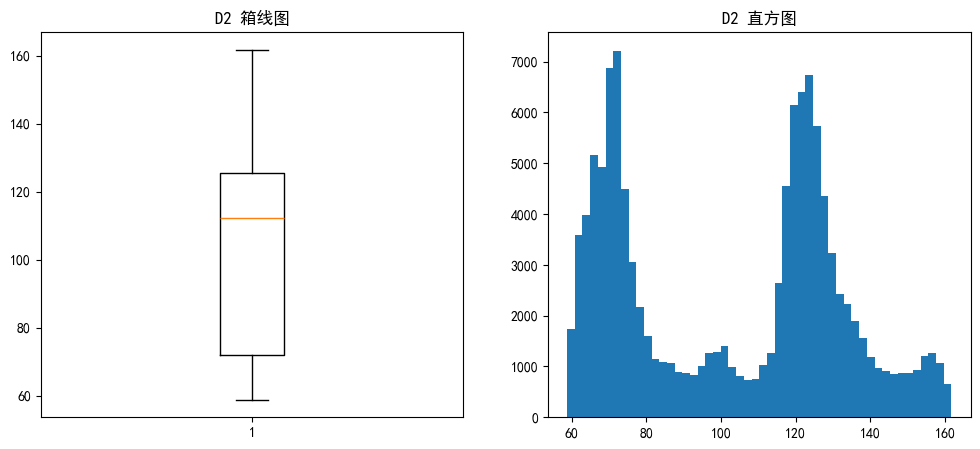


=== 处理列 'D3' ===

检查列 'D3' 的数据状态：
列 'D3' 分布分析：
- 有效数据量：122343
- 最小值：28.90, 最大值：78.80
- 低值区 (<5.0) 比例：0.00%
- 偏度：0.00, 峰值数量：0
推荐方法：IQR 方法
列 'D3' 无异常值

=== 处理列 'D4' ===

检查列 'D4' 的数据状态：
列 'D4' 分布分析：
- 有效数据量：122343
- 最小值：32.60, 最大值：100.20
- 低值区 (<5.0) 比例：0.00%
- 偏度：0.04, 峰值数量：0
推荐方法：IQR 方法
列 'D4' 无异常值

=== 处理列 '1号高加出水温度' ===

检查列 '1号高加出水温度' 的数据状态：
列 '1号高加出水温度' 分布分析：
- 有效数据量：122343
- 最小值：237.88, 最大值：285.34
- 低值区 (<5.0) 比例：0.00%
- 偏度：-0.26, 峰值数量：0
推荐方法：IQR 方法
列 '1号高加出水温度' 无异常值

=== 处理列 '1号高加疏水温度' ===

检查列 '1号高加疏水温度' 的数据状态：
列 '1号高加疏水温度' 分布分析：
- 有效数据量：122343
- 最小值：216.71, 最大值：266.66
- 低值区 (<5.0) 比例：0.00%
- 偏度：-0.21, 峰值数量：0
推荐方法：IQR 方法
列 '1号高加疏水温度' 无异常值

=== 处理列 '2号高加出水温度' ===

检查列 '2号高加出水温度' 的数据状态：
列 '2号高加出水温度' 分布分析：
- 有效数据量：122343
- 最小值：212.33, 最大值：254.91
- 低值区 (<5.0) 比例：0.00%
- 偏度：-0.28, 峰值数量：0
推荐方法：IQR 方法
列 '2号高加出水温度' 无异常值

=== 处理列 '2号高加疏水温度' ===

检查列 '2号高加疏水温度' 的数据状态：
列 '2号高加疏水温度' 分布分析：
- 有效数据量：122343
- 最小值：180.23, 最大值：218.33
- 低值区 (<5.0) 比例：0.00%
- 偏度：-0.29, 峰值数量：0
推荐方法：IQR 方法
列 '2号高加疏水

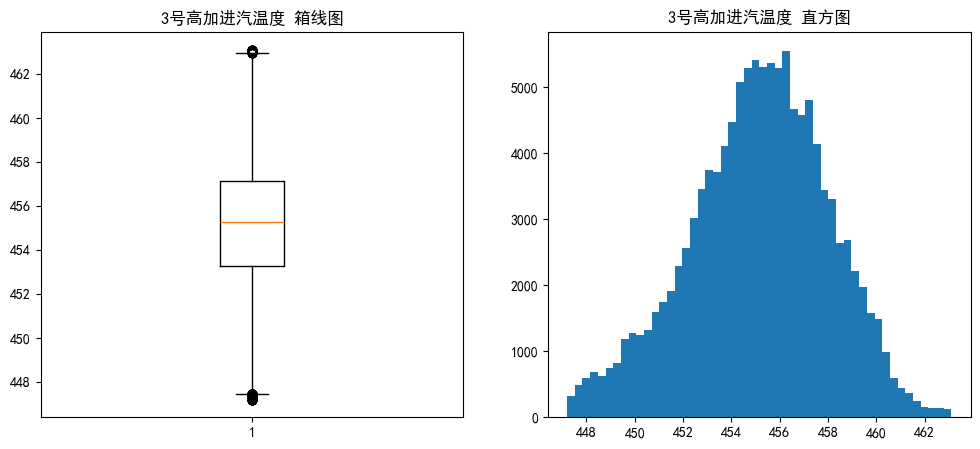


=== 处理列 'A汽泵密封水阀位' ===

检查列 'A汽泵密封水阀位' 的数据状态：
列 'A汽泵密封水阀位' 分布分析：
- 有效数据量：122343
- 最小值：20.61, 最大值：68.87
- 低值区 (<5.0) 比例：0.00%
- 偏度：-0.07, 峰值数量：0
推荐方法：IQR 方法
检测到 63 个异常值，占比 0.05%
异常值样本 - 最小值端： [62.12, 62.12, 62.18, 62.18, 62.18]
最大值端： [68.87, 68.54, 68.53, 68.52, 68.52]


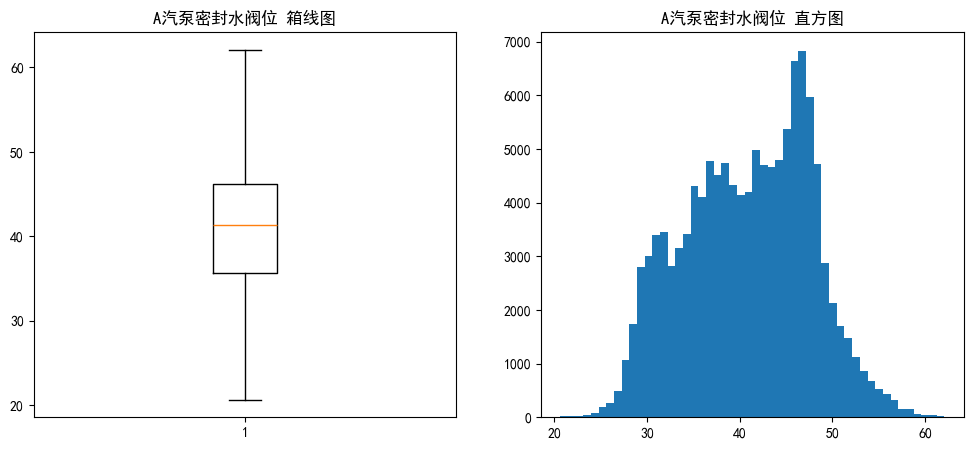


=== 处理列 'B汽泵密封水阀位' ===

检查列 'B汽泵密封水阀位' 的数据状态：
列 'B汽泵密封水阀位' 分布分析：
- 有效数据量：122343
- 最小值：27.99, 最大值：52.18
- 低值区 (<5.0) 比例：0.00%
- 偏度：-0.52, 峰值数量：1
推荐方法：IQR 方法
检测到 1302 个异常值，占比 1.06%
异常值样本 - 最小值端： [27.99, 28.05, 28.05, 28.05, 28.05]
最大值端： [52.18, 52.1, 51.78, 50.71, 50.12]


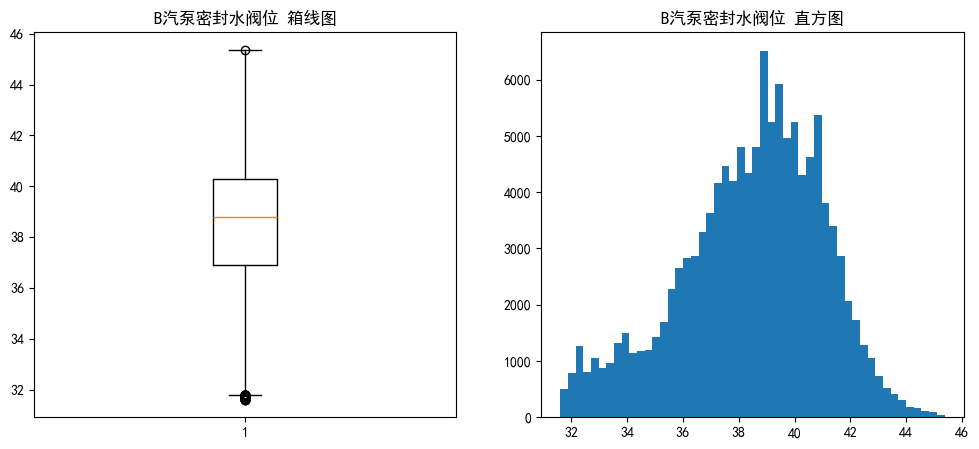


=== 处理列 'GV1阀位' ===

检查列 'GV1阀位' 的数据状态：
列 'GV1阀位' 分布分析：
- 有效数据量：122343
- 最小值：-0.56, 最大值：100.00
- 低值区 (<5.0) 比例：13.60%
- 偏度：4.10, 峰值数量：1
推荐方法：百分位法
检测到 2364 个异常值，占比 1.93%
异常值样本 - 最小值端： [-0.56, -0.46, -0.45, -0.32, 0.24]
最大值端： [100.0, 100.0, 100.0, 100.0, 100.0]


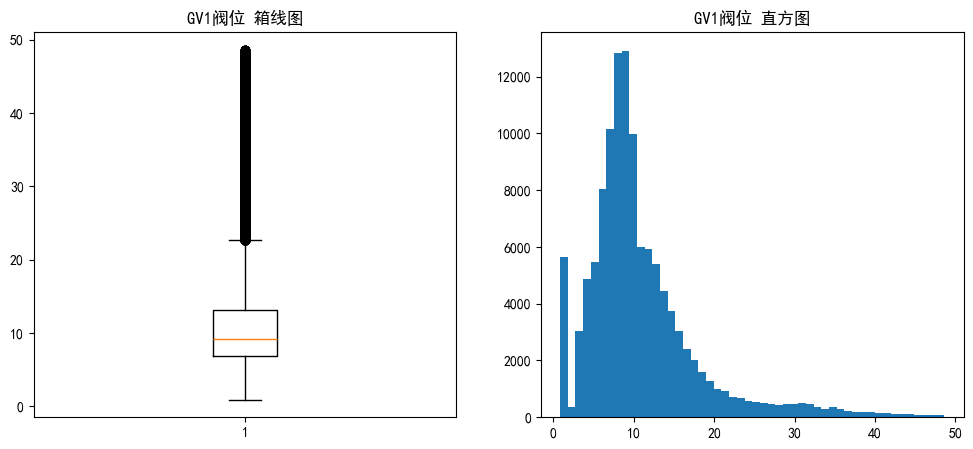


=== 处理列 'GV2阀位' ===

检查列 'GV2阀位' 的数据状态：
列 'GV2阀位' 分布分析：
- 有效数据量：122343
- 最小值：37.43, 最大值：100.00
- 低值区 (<5.0) 比例：0.00%
- 偏度：-0.27, 峰值数量：0
推荐方法：IQR 方法
列 'GV2阀位' 无异常值

=== 处理列 'GV3阀位' ===

检查列 'GV3阀位' 的数据状态：
列 'GV3阀位' 分布分析：
- 有效数据量：122343
- 最小值：37.46, 最大值：100.00
- 低值区 (<5.0) 比例：0.00%
- 偏度：-0.27, 峰值数量：0
推荐方法：IQR 方法
列 'GV3阀位' 无异常值

=== 处理列 'GV4阀位' ===

检查列 'GV4阀位' 的数据状态：
列 'GV4阀位' 分布分析：
- 有效数据量：122343
- 最小值：-0.52, 最大值：29.66
- 低值区 (<5.0) 比例：99.13%
- 偏度：11.32, 峰值数量：1
推荐方法：低值密集区处理
检测到 24 个异常值，占比 0.02%
异常值样本 - 最小值端： [20.45, 20.95, 21.01, 21.2, 21.25]
最大值端： [29.66, 29.44, 26.71, 24.18, 23.41]


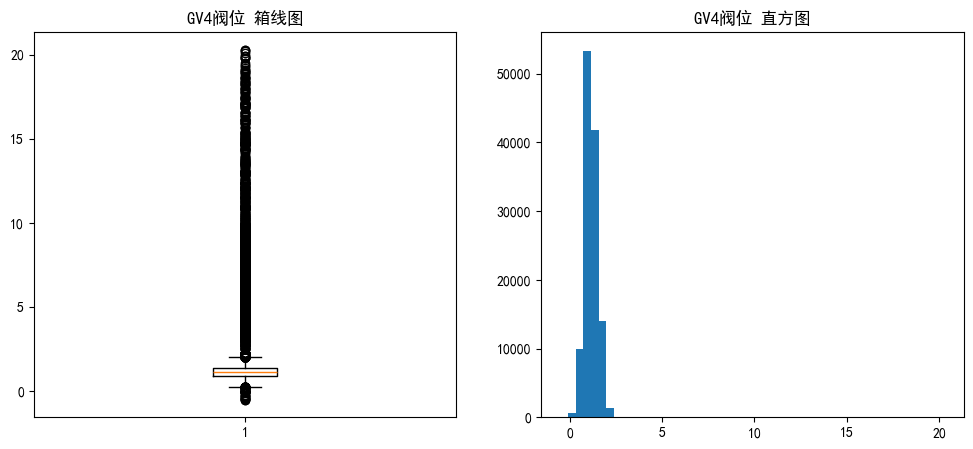


=== 处理列 '一段抽汽压力' ===

检查列 '一段抽汽压力' 的数据状态：
列 '一段抽汽压力' 分布分析：
- 有效数据量：122343
- 最小值：2.92, 最大值：6.55
- 低值区 (<5.0) 比例：52.70%
- 偏度：-0.10, 峰值数量：4
推荐方法：多峰处理
列 '一段抽汽压力' 无异常值

=== 处理列 '一段抽汽温度' ===

检查列 '一段抽汽温度' 的数据状态：
列 '一段抽汽温度' 分布分析：
- 有效数据量：122343
- 最小值：307.07, 最大值：370.49
- 低值区 (<5.0) 比例：0.00%
- 偏度：-0.03, 峰值数量：0
推荐方法：IQR 方法
检测到 5235 个异常值，占比 4.28%
异常值样本 - 最小值端： [307.07, 307.07, 307.22, 307.7, 307.97]
最大值端： [370.49, 370.49, 370.34, 370.2, 370.05]


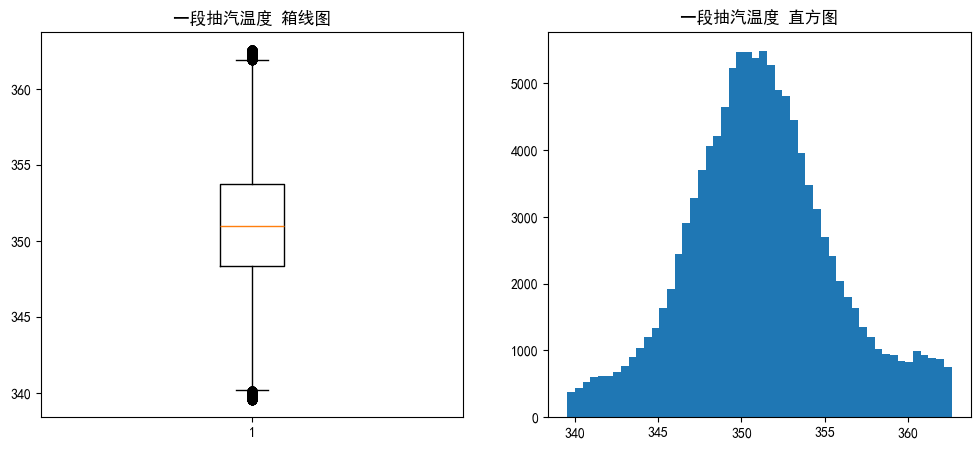


=== 处理列 '三段抽汽压力' ===

检查列 '三段抽汽压力' 的数据状态：
列 '三段抽汽压力' 分布分析：
- 有效数据量：122343
- 最小值：0.77, 最大值：1.83
- 低值区 (<5.0) 比例：100.00%
- 偏度：-0.13, 峰值数量：10
推荐方法：多峰处理
检测到 130 个异常值，占比 0.11%
异常值样本 - 最小值端： [0.89, 0.89, 0.89, 0.89, 0.89]
最大值端： [0.89, 0.89, 0.89, 0.89, 0.89]


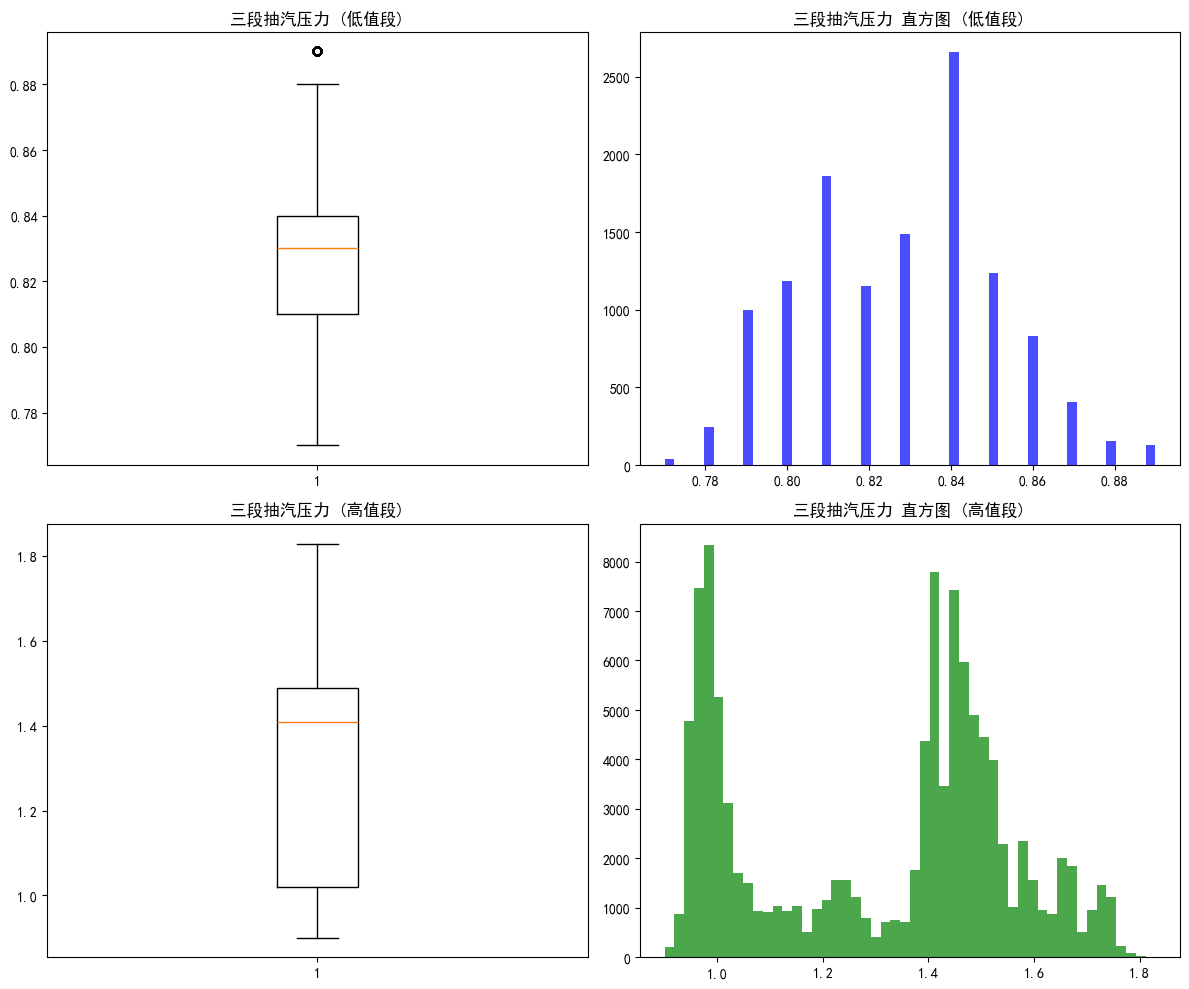


=== 处理列 '三段抽汽温度' ===

检查列 '三段抽汽温度' 的数据状态：
列 '三段抽汽温度' 分布分析：
- 有效数据量：122343
- 最小值：439.94, 最大值：471.07
- 低值区 (<5.0) 比例：0.00%
- 偏度：-0.49, 峰值数量：1
推荐方法：IQR 方法
检测到 3644 个异常值，占比 2.98%
异常值样本 - 最小值端： [439.94, 439.94, 439.94, 439.96, 440.18]
最大值端： [471.07, 471.07, 471.07, 471.07, 471.07]


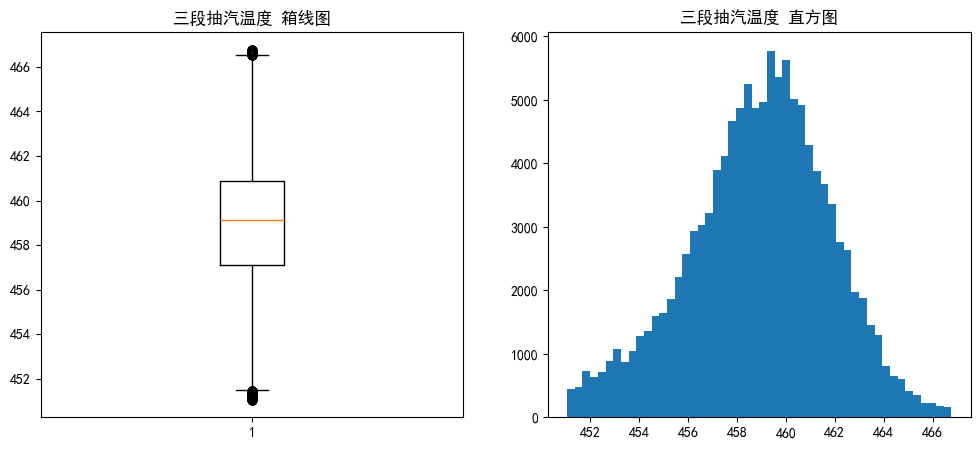


=== 处理列 '中压缸排汽压力' ===

检查列 '中压缸排汽压力' 的数据状态：
列 '中压缸排汽压力' 分布分析：
- 有效数据量：122343
- 最小值：419.75, 最大值：934.75
- 低值区 (<5.0) 比例：0.00%
- 偏度：-0.14, 峰值数量：0
推荐方法：IQR 方法
列 '中压缸排汽压力' 无异常值

=== 处理列 '主凝结水压力' ===

检查列 '主凝结水压力' 的数据状态：
列 '主凝结水压力' 分布分析：
- 有效数据量：122343
- 最小值：0.87, 最大值：1.53
- 低值区 (<5.0) 比例：100.00%
- 偏度：0.30, 峰值数量：13
推荐方法：多峰处理
检测到 7 个异常值，占比 0.01%
异常值样本 - 最小值端： [1.53, 1.53, 1.53, 1.53, 1.53]
最大值端： [1.53, 1.53, 1.53, 1.53, 1.53]


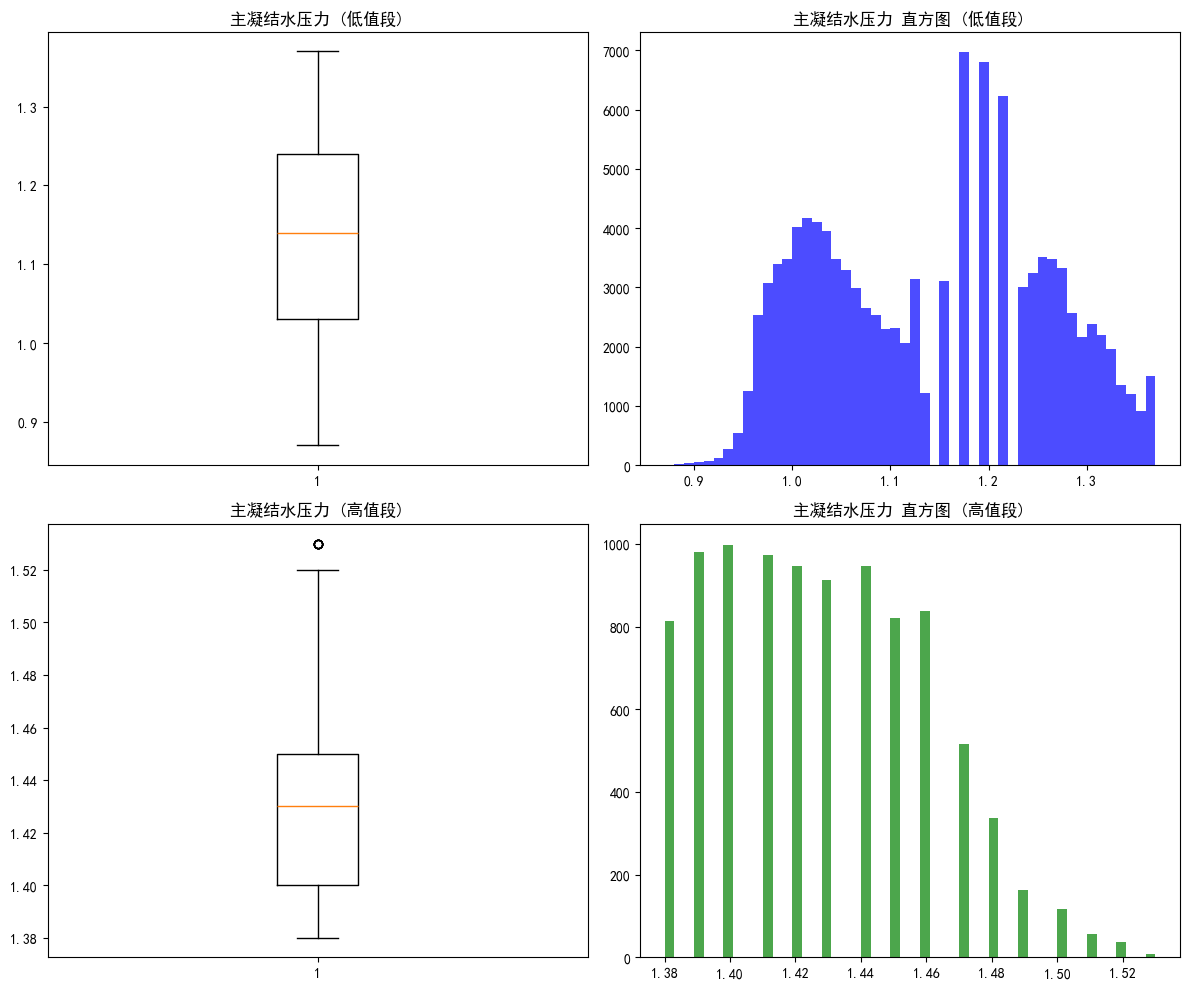


=== 处理列 '主汽压力' ===

检查列 '主汽压力' 的数据状态：
列 '主汽压力' 分布分析：
- 有效数据量：122343
- 最小值：14.34, 最大值：25.62
- 低值区 (<5.0) 比例：0.00%
- 偏度：-0.26, 峰值数量：2
推荐方法：多峰处理
检测到 2759 个异常值，占比 2.26%
异常值样本 - 最小值端： [20.76, 20.76, 20.76, 20.76, 20.76]
最大值端： [21.55, 21.55, 21.55, 21.55, 21.55]


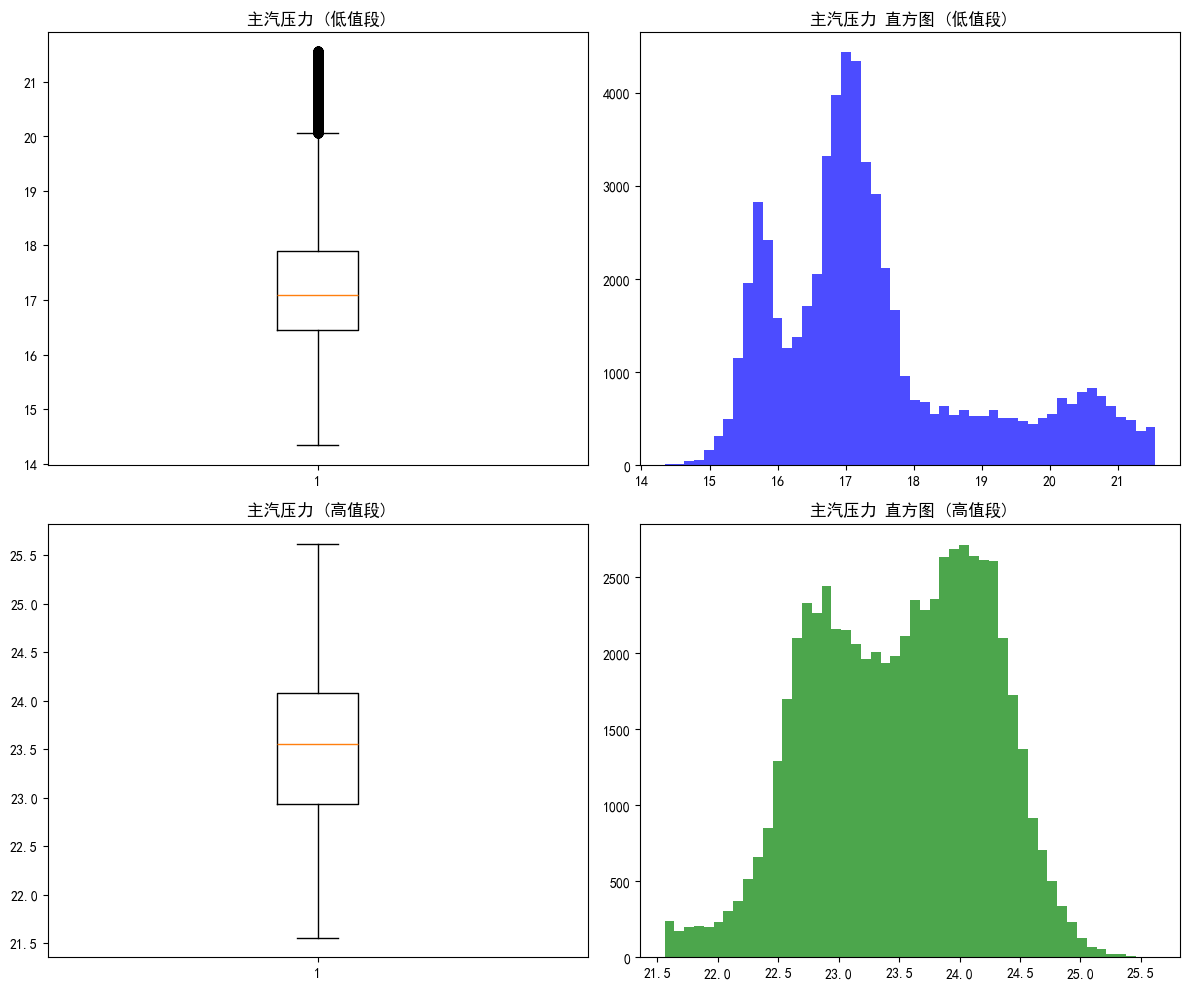


=== 处理列 '主给水流量' ===

检查列 '主给水流量' 的数据状态：
列 '主给水流量' 分布分析：
- 有效数据量：122343
- 最小值：716.65, 最大值：1766.40
- 低值区 (<5.0) 比例：0.00%
- 偏度：-0.03, 峰值数量：0
推荐方法：IQR 方法
列 '主给水流量' 无异常值

=== 处理列 '主蒸汽母管温度' ===

检查列 '主蒸汽母管温度' 的数据状态：
列 '主蒸汽母管温度' 分布分析：
- 有效数据量：122343
- 最小值：512.32, 最大值：572.43
- 低值区 (<5.0) 比例：0.00%
- 偏度：-2.16, 峰值数量：1
推荐方法：百分位法
检测到 2428 个异常值，占比 1.98%
异常值样本 - 最小值端： [512.32, 512.32, 512.6, 512.6, 513.01]
最大值端： [572.43, 572.32, 572.29, 572.23, 572.12]


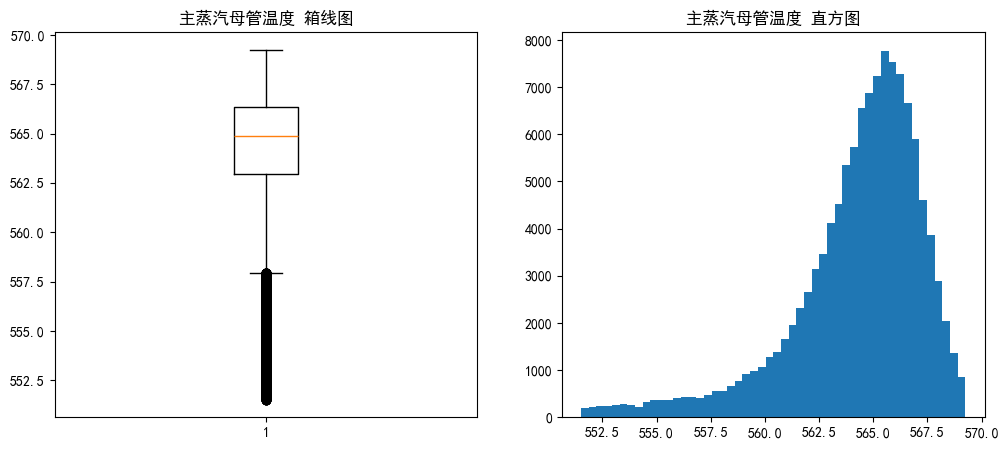


=== 处理列 '主蒸汽流量' ===

检查列 '主蒸汽流量' 的数据状态：
列 '主蒸汽流量' 分布分析：
- 有效数据量：122343
- 最小值：727.31, 最大值：1792.47
- 低值区 (<5.0) 比例：0.00%
- 偏度：-0.03, 峰值数量：0
推荐方法：IQR 方法
列 '主蒸汽流量' 无异常值

=== 处理列 '二段抽汽压力' ===

检查列 '二段抽汽压力' 的数据状态：
列 '二段抽汽压力' 分布分析：
- 有效数据量：122343
- 最小值：1.81, 最大值：4.15
- 低值区 (<5.0) 比例：100.00%
- 偏度：-0.12, 峰值数量：6
推荐方法：多峰处理
列 '二段抽汽压力' 无异常值

=== 处理列 '二段抽汽温度' ===

检查列 '二段抽汽温度' 的数据状态：
列 '二段抽汽温度' 分布分析：
- 有效数据量：122343
- 最小值：262.02, 最大值：312.99
- 低值区 (<5.0) 比例：0.00%
- 偏度：-0.32, 峰值数量：1
推荐方法：IQR 方法
检测到 4311 个异常值，占比 3.52%
异常值样本 - 最小值端： [262.02, 262.17, 262.17, 262.63, 262.82]
最大值端： [312.99, 312.85, 312.84, 312.69, 312.64]


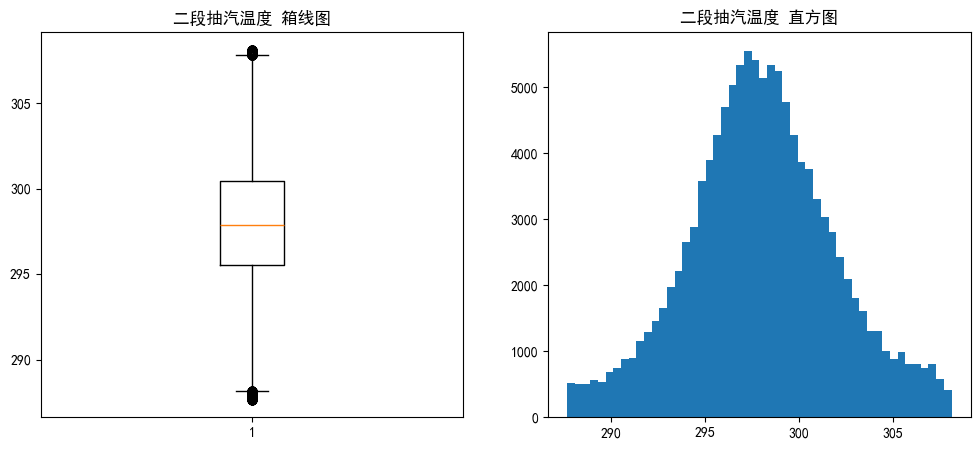


=== 处理列 '低压缸排汽压力A' ===

检查列 '低压缸排汽压力A' 的数据状态：
列 '低压缸排汽压力A' 分布分析：
- 有效数据量：122343
- 最小值：3.28, 最大值：7.76
- 低值区 (<5.0) 比例：40.50%
- 偏度：0.30, 峰值数量：4
推荐方法：多峰处理
列 '低压缸排汽压力A' 无异常值

=== 处理列 '低压缸排汽压力B' ===

检查列 '低压缸排汽压力B' 的数据状态：
列 '低压缸排汽压力B' 分布分析：
- 有效数据量：122343
- 最小值：3.28, 最大值：7.79
- 低值区 (<5.0) 比例：40.41%
- 偏度：0.29, 峰值数量：3
推荐方法：多峰处理
列 '低压缸排汽压力B' 无异常值

=== 处理列 '再减流量' ===

检查列 '再减流量' 的数据状态：
列 '再减流量' 分布分析：
- 有效数据量：122343
- 最小值：0.00, 最大值：89.51
- 低值区 (<5.0) 比例：5.57%
- 偏度：-0.17, 峰值数量：0
推荐方法：IQR 方法
列 '再减流量' 无异常值

=== 处理列 '再热减温水总管压力' ===

检查列 '再热减温水总管压力' 的数据状态：
列 '再热减温水总管压力' 分布分析：
- 有效数据量：122343
- 最小值：5.38, 最大值：10.95
- 低值区 (<5.0) 比例：0.00%
- 偏度：-0.03, 峰值数量：2
推荐方法：多峰处理
检测到 808 个异常值，占比 0.66%
异常值样本 - 最小值端： [5.38, 5.41, 5.42, 5.42, 5.43]
最大值端： [10.95, 10.93, 10.93, 10.88, 10.86]


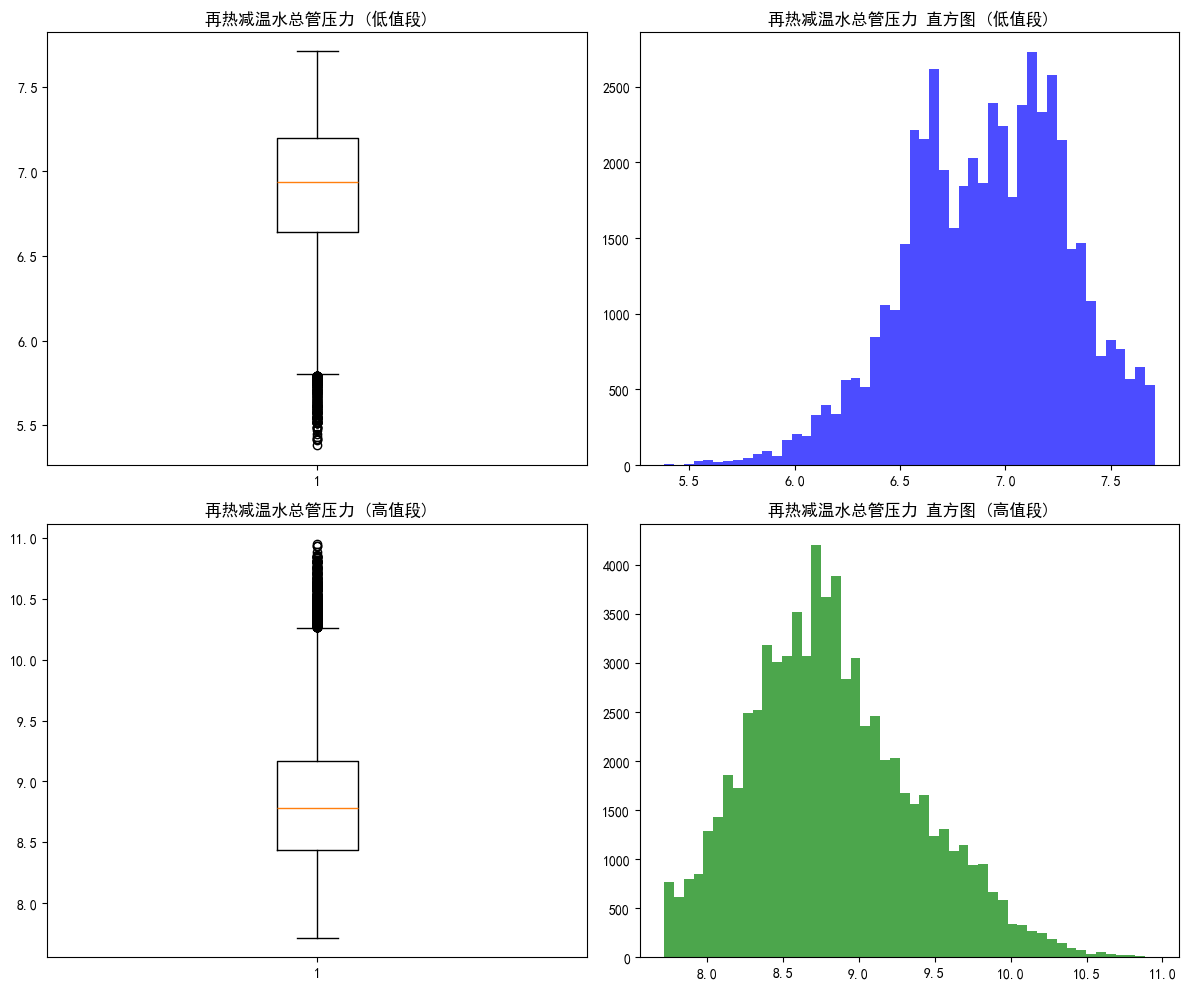


=== 处理列 '再热减温水总管温度' ===

检查列 '再热减温水总管温度' 的数据状态：
列 '再热减温水总管温度' 分布分析：
- 有效数据量：122343
- 最小值：136.39, 最大值：177.14
- 低值区 (<5.0) 比例：0.00%
- 偏度：-0.33, 峰值数量：1
推荐方法：IQR 方法
列 '再热减温水总管温度' 无异常值

=== 处理列 '再热汽压力' ===

检查列 '再热汽压力' 的数据状态：
列 '再热汽压力' 分布分析：
- 有效数据量：122343
- 最小值：1.72, 最大值：3.97
- 低值区 (<5.0) 比例：100.00%
- 偏度：-0.12, 峰值数量：6
推荐方法：多峰处理
列 '再热汽压力' 无异常值

=== 处理列 '再热汽母管温度' ===

检查列 '再热汽母管温度' 的数据状态：
列 '再热汽母管温度' 分布分析：
- 有效数据量：122343
- 最小值：534.87, 最大值：580.74
- 低值区 (<5.0) 比例：0.00%
- 偏度：-0.53, 峰值数量：1
推荐方法：IQR 方法
检测到 4490 个异常值，占比 3.67%
异常值样本 - 最小值端： [534.87, 534.9, 534.91, 534.94, 535.11]
最大值端： [580.74, 580.74, 580.74, 580.73, 580.61]


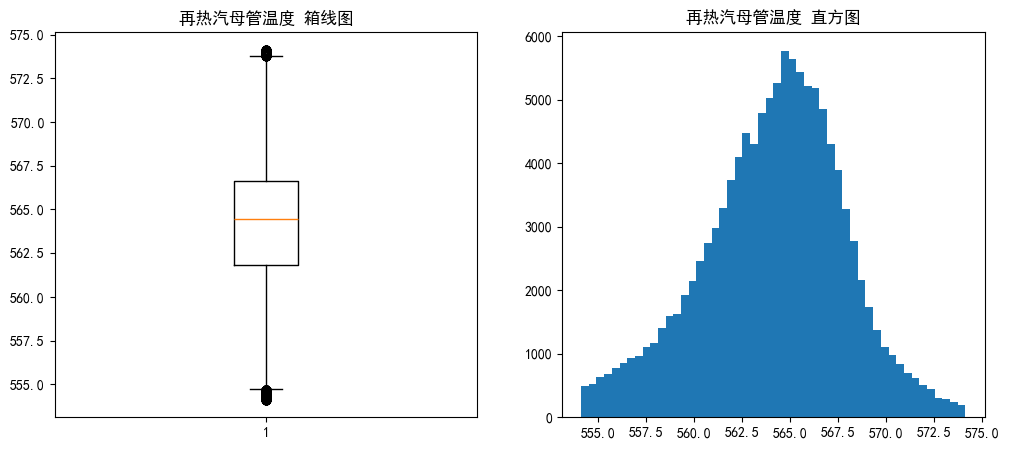


=== 处理列 '减温水流量' ===

检查列 '减温水流量' 的数据状态：
列 '减温水流量' 分布分析：
- 有效数据量：122343
- 最小值：0.38, 最大值：204.84
- 低值区 (<5.0) 比例：1.80%
- 偏度：0.48, 峰值数量：0
推荐方法：IQR 方法
检测到 856 个异常值，占比 0.70%
异常值样本 - 最小值端： [151.5, 151.5, 151.5, 151.5, 151.56]
最大值端： [204.84, 204.84, 204.39, 201.36, 201.36]


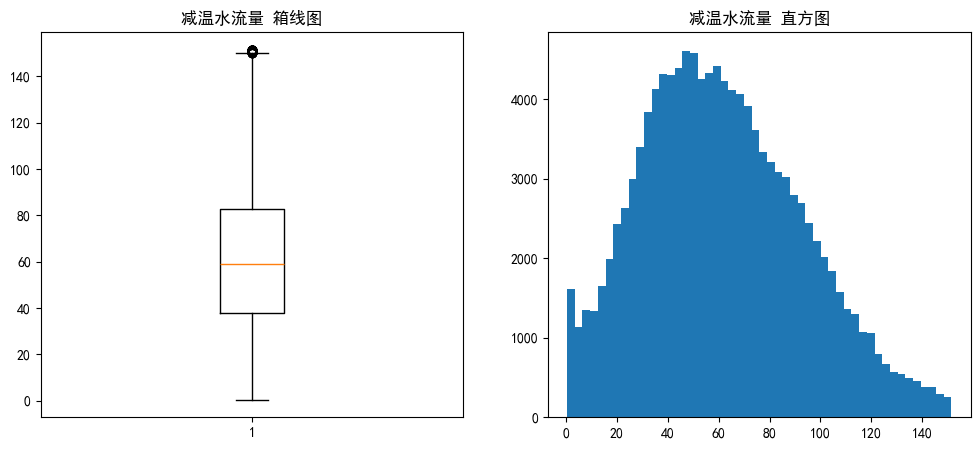


=== 处理列 '凝结水流量' ===

检查列 '凝结水流量' 的数据状态：
列 '凝结水流量' 分布分析：
- 有效数据量：122343
- 最小值：626.65, 最大值：1522.19
- 低值区 (<5.0) 比例：0.00%
- 偏度：0.00, 峰值数量：0
推荐方法：IQR 方法
列 '凝结水流量' 无异常值

=== 处理列 '凝结水补水流量' ===

检查列 '凝结水补水流量' 的数据状态：
列 '凝结水补水流量' 分布分析：
- 有效数据量：122343
- 最小值：0.00, 最大值：166.22
- 低值区 (<5.0) 比例：66.18%
- 偏度：1.88, 峰值数量：0
推荐方法：低值密集区处理
检测到 19 个异常值，占比 0.02%
异常值样本 - 最小值端： [163.2, 163.2, 163.31, 163.33, 163.35]
最大值端： [166.22, 165.99, 164.7, 164.34, 164.34]


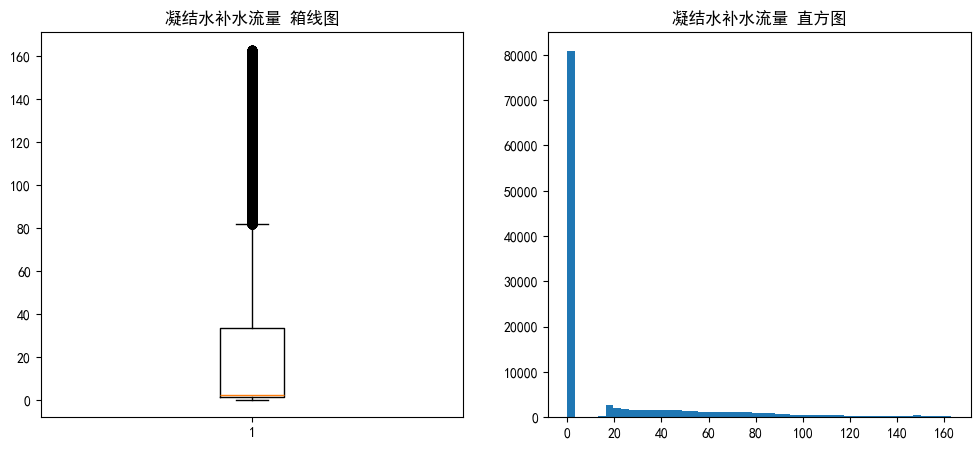


=== 处理列 '厂用电率' ===

检查列 '厂用电率' 的数据状态：
列 '厂用电率' 分布分析：
- 有效数据量：122343
- 最小值：4.00, 最大值：7.83
- 低值区 (<5.0) 比例：18.11%
- 偏度：0.54, 峰值数量：2
推荐方法：多峰处理
列 '厂用电率' 无异常值

=== 处理列 '吹灰蒸汽压力' ===

检查列 '吹灰蒸汽压力' 的数据状态：
列 '吹灰蒸汽压力' 分布分析：
- 有效数据量：122343
- 最小值：0.00, 最大值：3.34
- 低值区 (<5.0) 比例：100.00%
- 偏度：0.78, 峰值数量：2
推荐方法：多峰处理
异常值占比 13.98% 过高，调整 IQR 倍数...
异常值占比 12.96% 过高，调整 IQR 倍数...
异常值占比 12.25% 过高，调整 IQR 倍数...
检测到 14418 个异常值，占比 11.78%
警告：异常值占比超过 5.0%
异常值样本 - 最小值端： [0.01, 0.01, 0.01, 0.01, 0.01]
最大值端： [3.34, 3.34, 3.33, 3.33, 3.32]


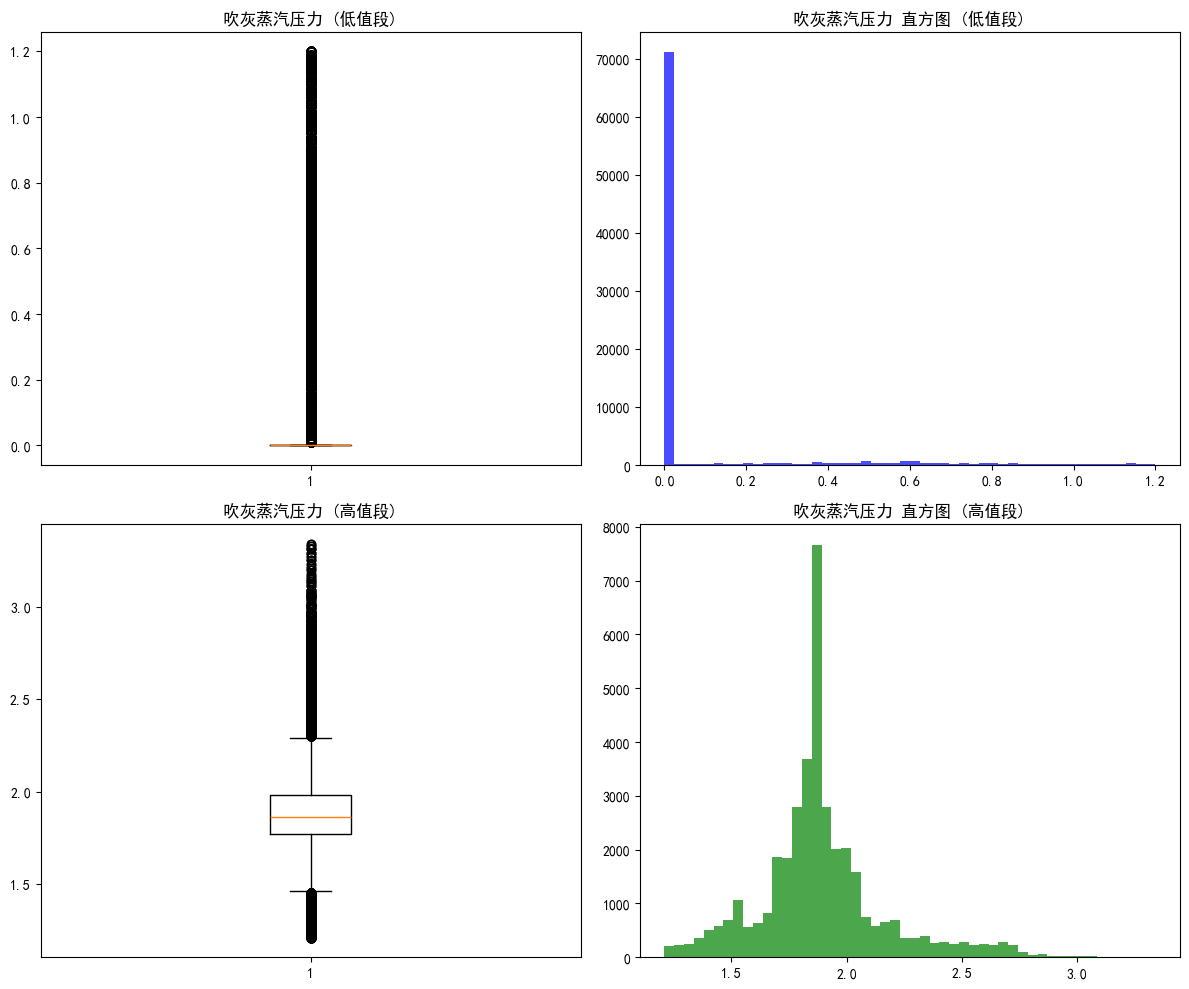


=== 处理列 '四段抽汽压力' ===

检查列 '四段抽汽压力' 的数据状态：
列 '四段抽汽压力' 分布分析：
- 有效数据量：122343
- 最小值：0.37, 最大值：0.89
- 低值区 (<5.0) 比例：100.00%
- 偏度：-0.15, 峰值数量：8
推荐方法：多峰处理
检测到 1012 个异常值，占比 0.83%
异常值样本 - 最小值端： [0.37, 0.37, 0.37, 0.37, 0.37]
最大值端： [0.43, 0.43, 0.43, 0.43, 0.43]


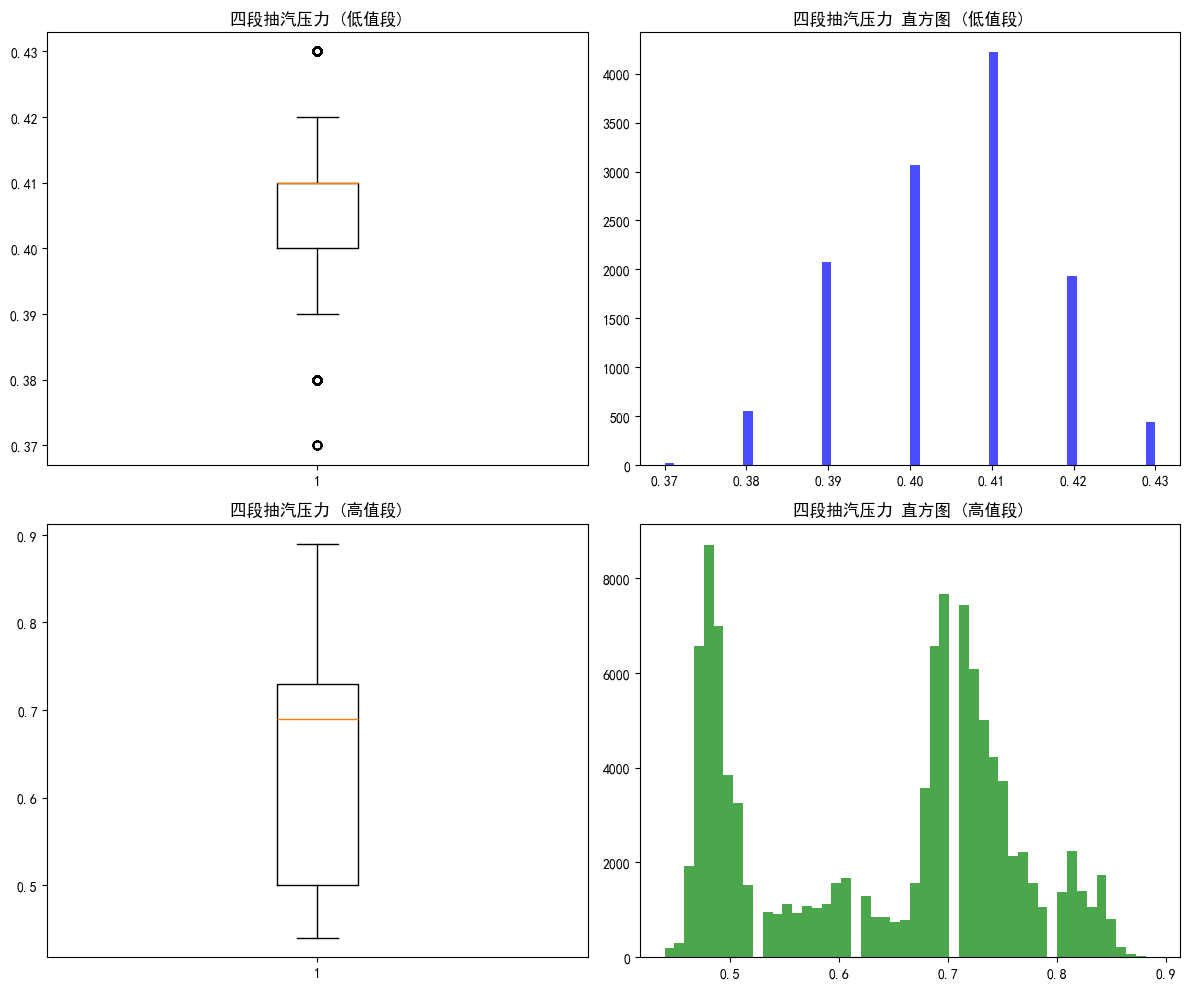


=== 处理列 '省煤器进口给水压力' ===

检查列 '省煤器进口给水压力' 的数据状态：
列 '省煤器进口给水压力' 分布分析：
- 有效数据量：122343
- 最小值：15.81, 最大值：28.75
- 低值区 (<5.0) 比例：0.00%
- 偏度：-0.23, 峰值数量：2
推荐方法：多峰处理
异常值占比 3.17% 过高，调整 IQR 倍数...
异常值占比 3.04% 过高，调整 IQR 倍数...
检测到 1131 个异常值，占比 0.92%
异常值样本 - 最小值端： [23.39, 23.39, 23.39, 23.39, 23.39]
最大值端： [23.83, 23.83, 23.83, 23.83, 23.83]


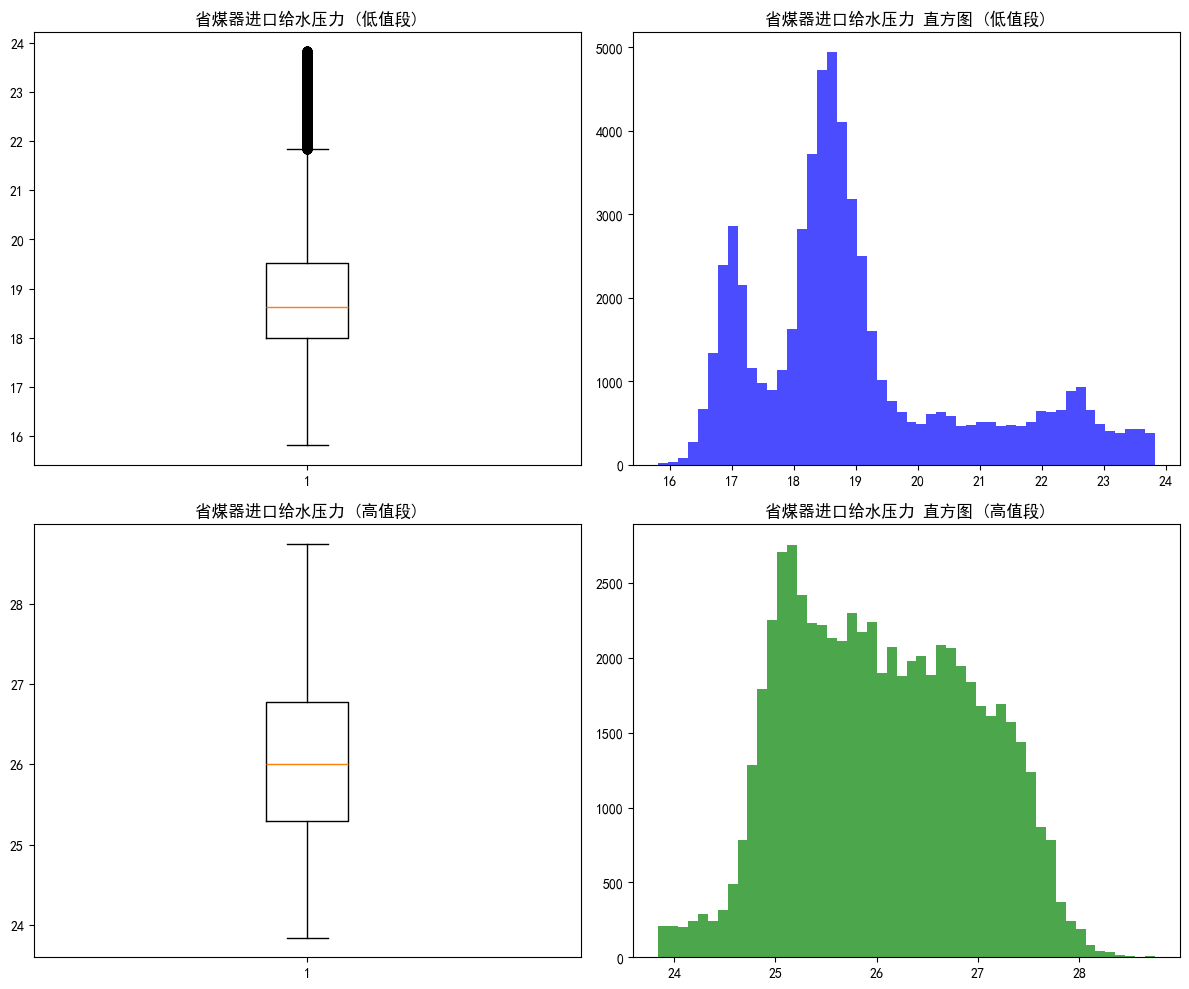


=== 处理列 '省煤器进口给水温度' ===

检查列 '省煤器进口给水温度' 的数据状态：
列 '省煤器进口给水温度' 分布分析：
- 有效数据量：122343
- 最小值：237.77, 最大值：284.56
- 低值区 (<5.0) 比例：0.00%
- 偏度：-0.26, 峰值数量：0
推荐方法：IQR 方法
列 '省煤器进口给水温度' 无异常值

=== 处理列 '给泵出口母管压力' ===

检查列 '给泵出口母管压力' 的数据状态：
列 '给泵出口母管压力' 分布分析：
- 有效数据量：122343
- 最小值：15.93, 最大值：29.17
- 低值区 (<5.0) 比例：0.00%
- 偏度：-0.22, 峰值数量：2
推荐方法：多峰处理
异常值占比 3.05% 过高，调整 IQR 倍数...
检测到 3558 个异常值，占比 2.91%
异常值样本 - 最小值端： [22.88, 22.88, 22.88, 22.88, 22.88]
最大值端： [24.13, 24.13, 24.13, 24.13, 24.13]


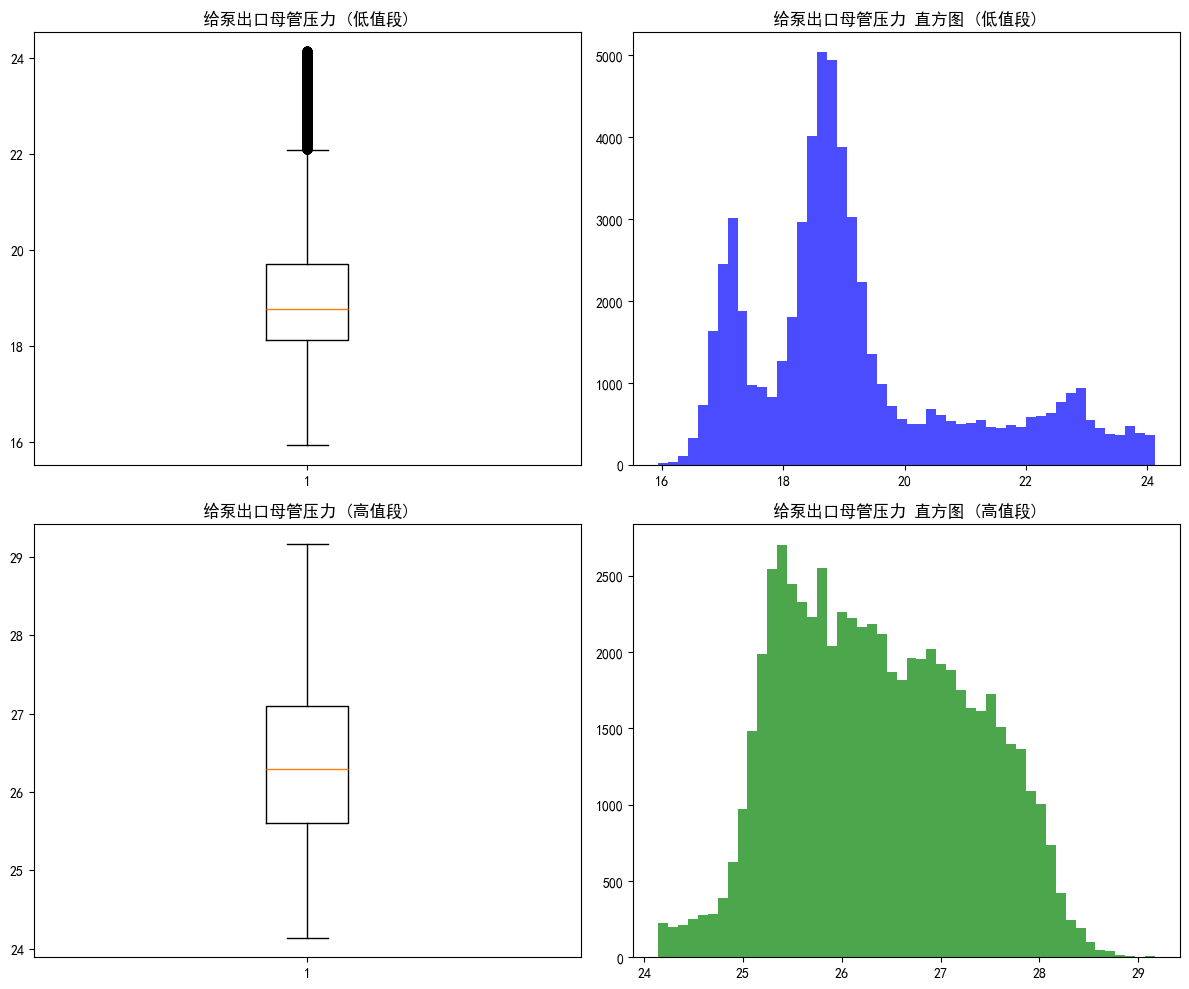


=== 处理列 '锅炉效率' ===

检查列 '锅炉效率' 的数据状态：
列 '锅炉效率' 分布分析：
- 有效数据量：122343
- 最小值：91.95, 最大值：99.58
- 低值区 (<5.0) 比例：0.00%
- 偏度：-0.43, 峰值数量：1
推荐方法：IQR 方法
检测到 1321 个异常值，占比 1.08%
异常值样本 - 最小值端： [91.95, 91.95, 91.96, 91.96, 91.97]
最大值端： [99.58, 99.58, 95.67, 94.98, 94.98]


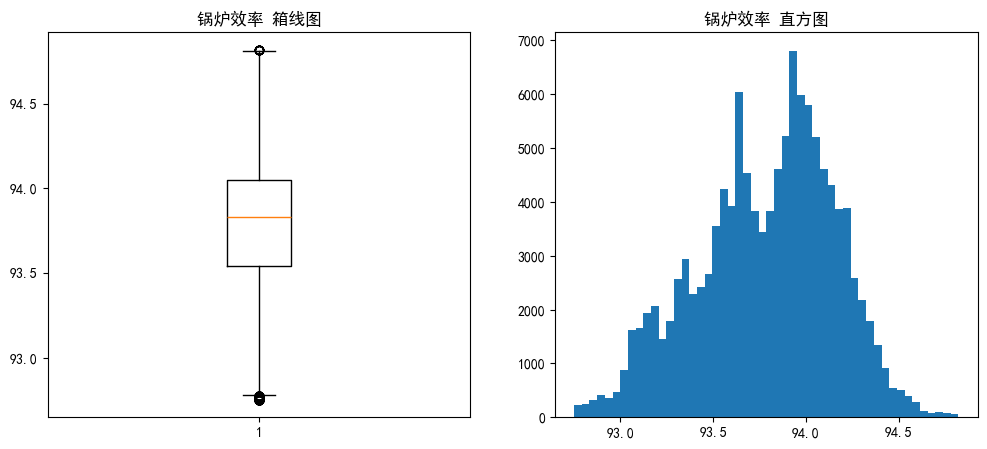


=== 处理列 '除氧器下水温度1' ===

检查列 '除氧器下水温度1' 的数据状态：
列 '除氧器下水温度1' 分布分析：
- 有效数据量：122343
- 最小值：146.14, 最大值：176.89
- 低值区 (<5.0) 比例：0.00%
- 偏度：-0.30, 峰值数量：1
推荐方法：IQR 方法
列 '除氧器下水温度1' 无异常值

=== 处理列 '除氧器下水温度2' ===

检查列 '除氧器下水温度2' 的数据状态：
列 '除氧器下水温度2' 分布分析：
- 有效数据量：122343
- 最小值：145.63, 最大值：176.47
- 低值区 (<5.0) 比例：0.00%
- 偏度：-0.31, 峰值数量：1
推荐方法：IQR 方法
列 '除氧器下水温度2' 无异常值

=== 处理列 '除氧器进水温度' ===

检查列 '除氧器进水温度' 的数据状态：
列 '除氧器进水温度' 分布分析：
- 有效数据量：122343
- 最小值：113.72, 最大值：137.02
- 低值区 (<5.0) 比例：0.00%
- 偏度：-0.32, 峰值数量：2
推荐方法：多峰处理
异常值占比 4.41% 过高，调整 IQR 倍数...
列 '除氧器进水温度' 无异常值

=== 处理列 '除氧器进汽温度' ===

检查列 '除氧器进汽温度' 的数据状态：
列 '除氧器进汽温度' 分布分析：
- 有效数据量：122343
- 最小值：332.31, 最大值：359.60
- 低值区 (<5.0) 比例：0.00%
- 偏度：-0.52, 峰值数量：1
推荐方法：IQR 方法
检测到 2960 个异常值，占比 2.42%
异常值样本 - 最小值端： [332.31, 332.32, 332.33, 332.33, 332.33]
最大值端： [359.6, 359.59, 359.58, 359.58, 359.56]


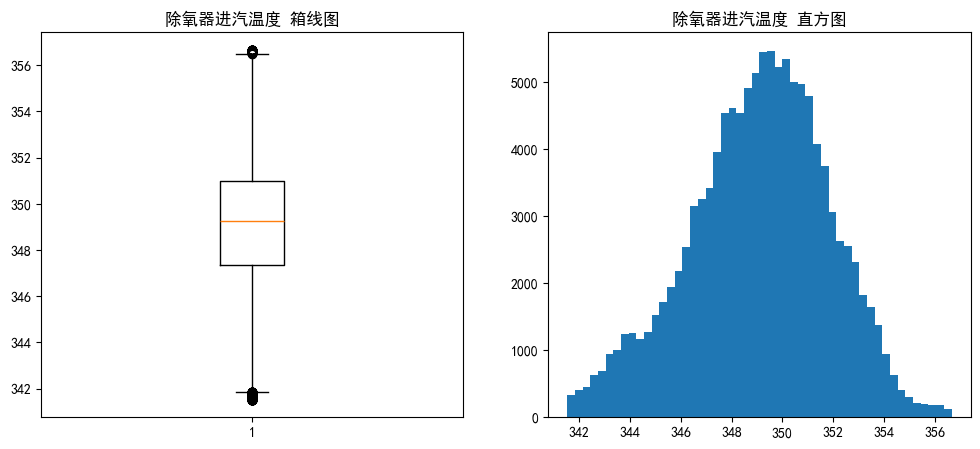


=== 处理列 '高压缸排汽压力' ===

检查列 '高压缸排汽压力' 的数据状态：
列 '高压缸排汽压力' 分布分析：
- 有效数据量：122343
- 最小值：1.88, 最大值：4.29
- 低值区 (<5.0) 比例：100.00%
- 偏度：-0.11, 峰值数量：5
推荐方法：多峰处理
列 '高压缸排汽压力' 无异常值

=== 处理列 '高压缸排汽温度' ===

检查列 '高压缸排汽温度' 的数据状态：
列 '高压缸排汽温度' 分布分析：
- 有效数据量：122343
- 最小值：261.63, 最大值：299.87
- 低值区 (<5.0) 比例：0.00%
- 偏度：-0.31, 峰值数量：1
推荐方法：IQR 方法
检测到 5188 个异常值，占比 4.24%
异常值样本 - 最小值端： [261.63, 261.65, 261.67, 261.7, 261.76]
最大值端： [299.87, 299.87, 299.87, 299.87, 299.85]


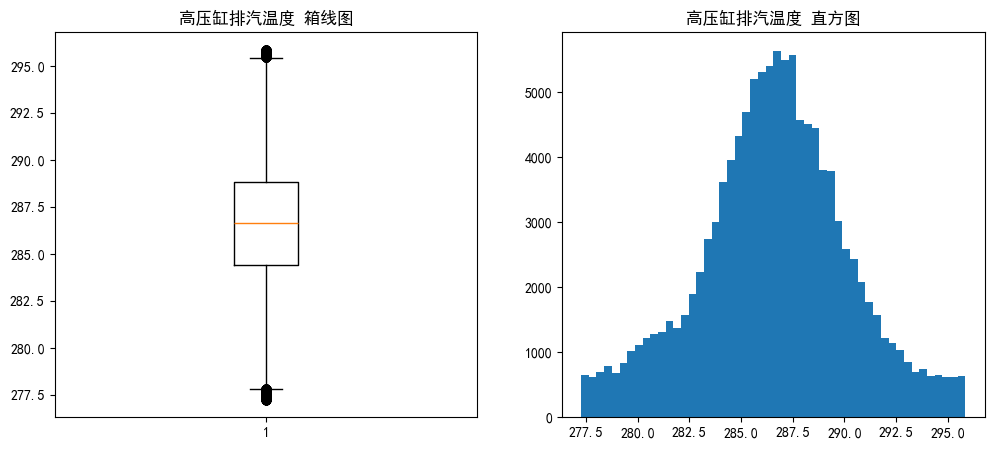

处理后的数据已保存至：/content/drive/My Drive/cleaned_results.csv

最终数据预览：
                时间    机组负荷  汽轮机热耗率q  修正后热耗率q    修正系数   高压缸效率   中压缸效率  低压缸排汽压力  \
0  2023/4/25 0:00  474.30   7693.0   7706.1  0.9983  86.078  96.115     4.06   
1  2023/4/25 0:00  476.03   7684.0   7699.4  0.9980  86.361  95.944     4.06   
2  2023/4/25 0:00  472.13   7687.2   7699.5  0.9984  86.173  96.010     4.08   
3  2023/4/25 0:01  470.13   7710.7   7723.8  0.9983  86.236  95.807     4.08   
4  2023/4/25 0:01  469.86   7909.1   7919.4  0.9987  86.802  95.720     4.08   

   主给水流量c     Dms  ...  省煤器进口给水压力  省煤器进口给水温度  给泵出口母管压力  锅炉效率  除氧器下水温度1  \
0  1287.2  1284.2  ...      24.63     263.67     24.83   NaN    165.92   
1  1290.2  1287.2  ...      24.58     263.69     24.78   NaN    166.08   
2  1280.1  1277.2  ...      24.54     263.70     24.74   NaN    166.08   
3  1278.3  1275.4  ...      24.49     263.70     24.69   NaN    166.24   
4  1309.0  1306.0  ...      24.43     263.43     24.64   NaN    166.25   

   除氧器下水温

In [ ]:
def analyze_distribution(df, column_name, bins=50, low_value_threshold=5.0):
    """分析数据分布并推荐异常值检测方法"""
    data = df[column_name].dropna()
    if len(data) == 0:
        print(f"列 '{column_name}' 无有效数据，跳过分析")
        return None

    hist, bin_edges = np.histogram(data, bins=bins, density=True)
    peaks, _ = find_peaks(hist, prominence=0.1)
    data_skew = skew(data)
    low_value_ratio = (data < low_value_threshold).sum() / len(data) * 100

    print(f"列 '{column_name}' 分布分析：")
    print(f"- 有效数据量：{len(data)}")
    print(f"- 最小值：{data.min():.2f}, 最大值：{data.max():.2f}")
    print(f"- 低值区 (<{low_value_threshold}) 比例：{low_value_ratio:.2f}%")
    print(f"- 偏度：{data_skew:.2f}, 峰值数量：{len(peaks)}")

    if len(peaks) > 1:
        method = 'multi_peak'
        print("推荐方法：多峰处理")
    elif low_value_ratio > 40 and abs(data_skew) > 1:
        method = 'low_value_dense'
        print("推荐方法：低值密集区处理")
    elif abs(data_skew) > 1:
        method = 'percentile'
        print("推荐方法：百分位法")
    else:
        method = 'IQR'
        print("推荐方法：IQR 方法")
    return method

def detect_and_clean_outliers_auto(df, column_name, low_value_threshold=5.0, iqr_multiplier=1.5,
                                   percentile_bounds=(1, 99), high_outlier_threshold=5.0, max_outlier_ratio=5.0):
    """自动检测和清理异常值"""
    print(f"\n检查列 '{column_name}' 的数据状态：")
    data = df[column_name].dropna()
    if len(data) == 0:
        print(f"列 '{column_name}' 无有效数据，跳过处理")
        return False, None, None, None

    method = analyze_distribution(df, column_name, low_value_threshold=low_value_threshold)
    if method is None:
        return False, None, None, None

    outliers = pd.Series(dtype=float)
    low_data, high_data, split_point = None, None, None

    if method == 'multi_peak':
        hist, bin_edges = np.histogram(data, bins=50, density=True)
        peaks, _ = find_peaks(hist, prominence=0.1)
        if len(peaks) > 1:
            valleys, _ = find_peaks(-hist, prominence=0.05)
            split_point = bin_edges[valleys[np.argmin(hist[valleys])]] if len(valleys) > 0 else \
                          (bin_edges[peaks[0]] + bin_edges[peaks[-1]]) / 2
            low_data = data[data <= split_point]
            high_data = data[data > split_point]
            outliers_idx = []

            for segment, label in [(low_data, '低值段'), (high_data, '高值段')]:
                if len(segment) > 0:
                    segment_skew = skew(segment)
                    adjusted_iqr = iqr_multiplier + 0.5 * abs(segment_skew) if abs(segment_skew) > 0.5 else iqr_multiplier
                    Q1, Q3 = segment.quantile(0.25), segment.quantile(0.75)
                    IQR = Q3 - Q1
                    lower_bound = Q1 - adjusted_iqr * IQR
                    upper_bound = Q3 + adjusted_iqr * IQR
                    segment_outliers = segment[(segment < lower_bound) | (segment > upper_bound)]
                    outliers_idx.extend(segment_outliers.index)

            outliers = data.loc[outliers_idx]
            outlier_ratio = len(outliers) / len(df) * 100

            while outlier_ratio > max_outlier_ratio and adjusted_iqr < 3.0:
                print(f"异常值占比 {outlier_ratio:.2f}% 过高，调整 IQR 倍数...")
                adjusted_iqr += 0.5
                outliers_idx = []
                for segment in [low_data, high_data]:
                    if len(segment) > 0:
                        Q1, Q3 = segment.quantile(0.25), segment.quantile(0.75)
                        IQR = Q3 - Q1
                        lower_bound = Q1 - adjusted_iqr * IQR
                        upper_bound = Q3 + adjusted_iqr * IQR
                        segment_outliers = segment[(segment < lower_bound) | (segment > upper_bound)]
                        outliers_idx.extend(segment_outliers.index)
                outliers = data.loc[outliers_idx]
                outlier_ratio = len(outliers) / len(df) * 100

            df.loc[outliers_idx, column_name] = np.nan

    elif method == 'low_value_dense':
        low_mask = df[column_name] < low_value_threshold
        high_data = data[~low_mask.reindex(data.index, fill_value=False)]
        if len(high_data) > 0:
            Q1, Q3 = high_data.quantile(0.25), high_data.quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - iqr_multiplier * IQR
            upper_bound = Q3 + iqr_multiplier * IQR
            outliers = high_data[(high_data < lower_bound) | (high_data > upper_bound)]
            df.loc[outliers.index, column_name] = np.nan

    elif method == 'percentile':
        lower_bound, upper_bound = np.percentile(data, percentile_bounds)
        outliers = data[(data < lower_bound) | (data > upper_bound)]
        df.loc[outliers.index, column_name] = np.nan

    else:  # IQR
        Q1, Q3 = data.quantile(0.25), data.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - iqr_multiplier * IQR
        upper_bound = Q3 + iqr_multiplier * IQR
        outliers = data[(data < lower_bound) | (data > upper_bound)]
        df.loc[outliers.index, column_name] = np.nan

    outlier_count = len(outliers)
    outlier_ratio = outlier_count / len(df) * 100

    if outlier_count == 0:
        print(f"列 '{column_name}' 无异常值")
        return False, None, None, None

    print(f"检测到 {outlier_count} 个异常值，占比 {outlier_ratio:.2f}%")
    if outlier_ratio > high_outlier_threshold:
        print(f"警告：异常值占比超过 {high_outlier_threshold}%")
    print(f"异常值样本 - 最小值端：", outliers.nsmallest(5).to_list())
    print(f"最大值端：", outliers.nlargest(5).to_list())
    return True, method, low_data, high_data

def plot_distribution(df, column_name, method, low_data=None, high_data=None):
    """绘制箱线图和直方图"""
    data = df[column_name].dropna()
    if len(data) == 0:
        print(f"列 '{column_name}' 无有效数据，跳过绘图")
        return

    if method == 'multi_peak' and low_data is not None and high_data is not None:
        plt.figure(figsize=(12, 10))
        plt.subplot(2, 2, 1)
        plt.boxplot(low_data)
        plt.title(f"{column_name} (低值段)")

        plt.subplot(2, 2, 2)
        plt.hist(low_data, bins=50, color='blue', alpha=0.7)
        plt.title(f"{column_name} 直方图 (低值段)")

        plt.subplot(2, 2, 3)
        plt.boxplot(high_data)
        plt.title(f"{column_name} (高值段)")

        plt.subplot(2, 2, 4)
        plt.hist(high_data, bins=50, color='green', alpha=0.7)
        plt.title(f"{column_name} 直方图 (高值段)")

        plt.tight_layout()
        plt.show()
    else:
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.boxplot(data)
        plt.title(f"{column_name} 箱线图")

        plt.subplot(1, 2, 2)
        plt.hist(data, bins=50)
        plt.title(f"{column_name} 直方图")
        plt.show()

# 处理数值列
numeric_columns = df.select_dtypes(include=[np.number]).columns
for col in numeric_columns:
    print(f"\n=== 处理列 '{col}' ===")
    has_outliers, method, low_data, high_data = detect_and_clean_outliers_auto(
        df, col, max_outlier_ratio=3.0
    )
    if has_outliers:
        plot_distribution(df, col, method, low_data, high_data)

# 保存清理后的数据
df.to_csv(SAVE_PATH, index=False)
print(f"处理后的数据已保存至：{SAVE_PATH}")
print("\n最终数据预览：\n", df.head())

## 稳态运行区间提取

### 合并相似的稳态区间

In [ ]:
def merge_similar_steady_intervals(df, steady_intervals, column_name='机组负荷',
                                  time_gap_threshold=5, load_diff_threshold=30):
    """合并相似的稳态区间

    参数:
    - df: 数据框
    - steady_intervals: 稳态区间列表，每个元素为 (start_idx, end_idx) 元组
    - column_name: 用于判断相似性的列名
    - time_gap_threshold: 时间间隔阈值（分钟），小于此阈值的间隔将被考虑合并
    - load_diff_threshold: 负荷差异阈值，小于此阈值的负荷差异将被考虑合并

    返回:
    - 合并后的稳态区间列表
    """
    if len(steady_intervals) <= 1:
        return steady_intervals

    # 转换为时间格式
    df['时间'] = pd.to_datetime(df['时间'])

    merged_intervals = []
    current_start, current_end = steady_intervals[0]
    current_avg = df.iloc[current_start:current_end+1][column_name].mean()

    for i in range(1, len(steady_intervals)):
        next_start, next_end = steady_intervals[i]
        next_avg = df.iloc[next_start:next_end+1][column_name].mean()

        # 计算时间间隔（分钟）
        time_gap = (df['时间'].iloc[next_start] - df['时间'].iloc[current_end]).total_seconds() / 60

        # 计算负荷差异
        load_diff = abs(next_avg - current_avg)

        # 如果时间间隔和负荷差异都小于阈值，则合并区间
        if time_gap < time_gap_threshold and load_diff < load_diff_threshold:
            current_end = next_end  # 扩展当前区间的结束位置
            # 更新合并后区间的平均值
            current_avg = df.iloc[current_start:current_end+1][column_name].mean()
        else:
            # 保存当前区间，开始新区间
            merged_intervals.append((current_start, current_end))
            current_start, current_end = next_start, next_end
            current_avg = next_avg

    # 添加最后一个区间
    merged_intervals.append((current_start, current_end))

    print(f"合并前稳态区间数量: {len(steady_intervals)}")
    print(f"合并后稳态区间数量: {len(merged_intervals)}")

    return merged_intervals

### 检测稳态运行区间

检测到 496 个稳态运行区间
稳态覆盖率: 81.75%
各稳态区间标准差: ['3.55', '3.40', '3.72', '3.43', '3.36', '0.76', '4.12', '1.91', '2.66', '2.65', '3.97', '0.62', '3.54', '3.06', '3.06', '2.50', '3.80', '2.59', '1.88', '2.65', '1.43', '3.28', '18.96', '3.08', '2.83', '4.29', '3.35', '2.78', '3.29', '2.38', '3.78', '1.99', '1.59', '3.01', '2.97', '3.31', '2.35', '3.61', '3.72', '4.24', '3.62', '7.91', '5.44', '2.82', '1.53', '2.64', '3.64', '2.83', '3.09', '3.46', '3.71', '3.49', '0.79', '1.95', '3.67', '4.00', '2.60', '2.84', '3.59', '3.66', '3.05', '3.28', '3.19', '3.74', '3.52', '3.06', '4.32', '1.57', '2.49', '1.58', '3.30', '2.76', '3.50', '2.14', '6.50', '3.20', '2.48', '3.17', '4.34', '2.26', '2.75', '1.74', '2.69', '3.48', '1.78', '6.56', '1.86', '1.77', '4.50', '3.92', '1.16', '3.09', '4.71', '1.79', '1.69', '1.96', '8.09', '4.36', '4.78', '2.18', '1.31', '2.02', '3.97', '3.14', '1.69', '2.14', '2.43', '4.88', '4.43', '3.65', '2.19', '3.03', '3.05', '2.63', '3.28', '5.09', '1.29', '2.93', '5.98', '3.59'

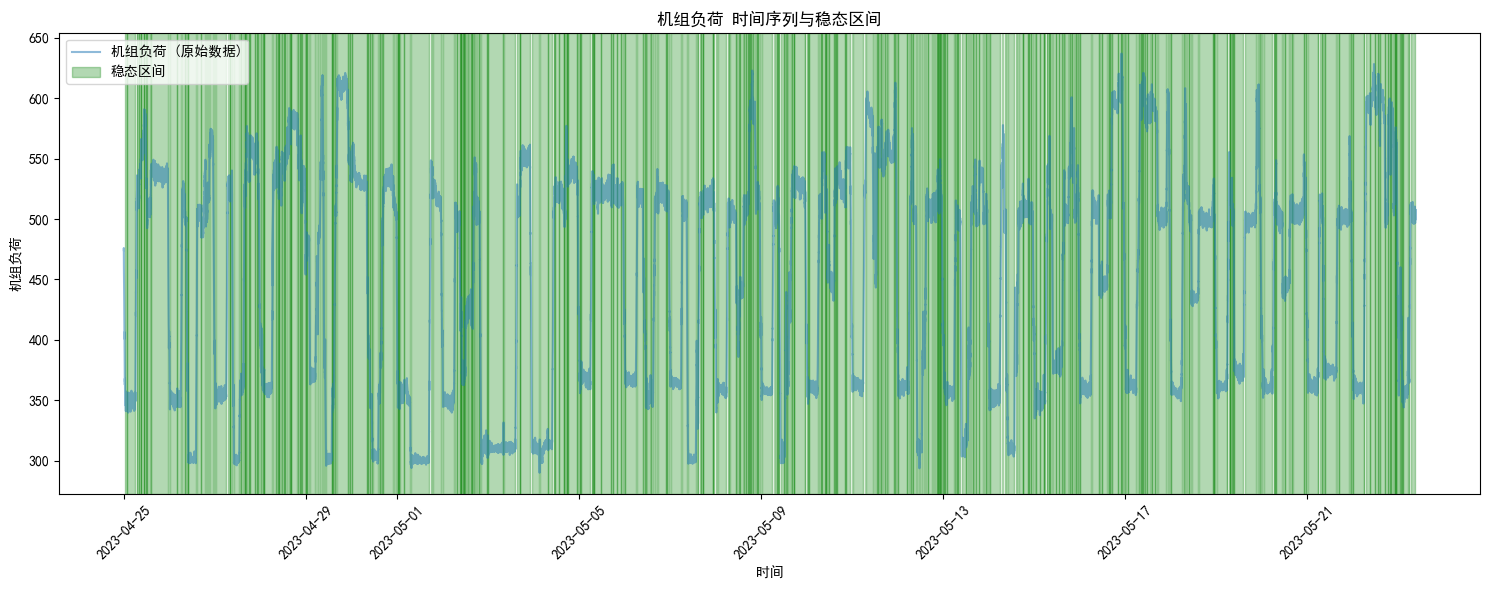

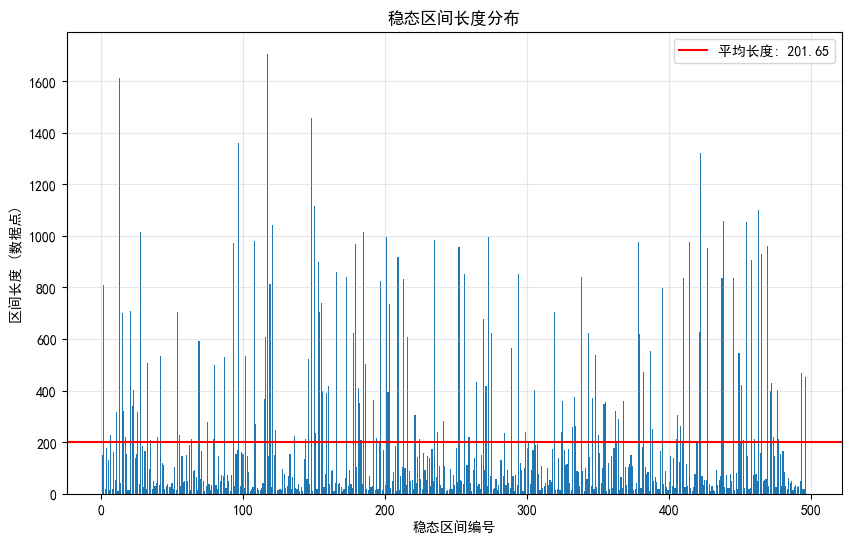

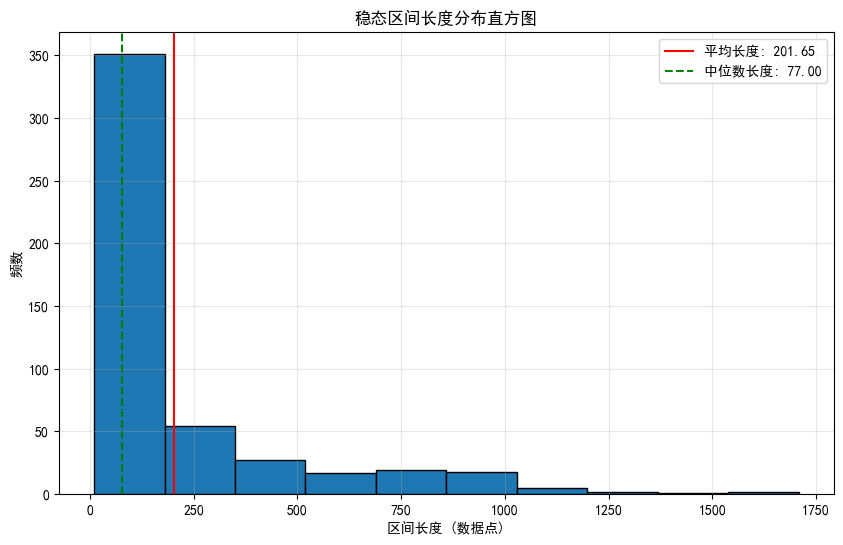

合并前稳态区间数量: 496
合并后稳态区间数量: 367
[固定阈值法] 检测到 1052 个稳态运行区间
[固定阈值法] 各稳态区间长度: [1149, 46, 38, 15, 211, 293, 79, 18, 20, 24, 201, 462, 239, 133, 316, 699, 252, 1326, 85, 55, 566, 681, 265, 380, 32, 143, 362, 10, 47, 10, 19, 65, 49, 16, 1422, 45, 165, 137, 100, 31, 56, 74, 961, 35, 33, 72, 30, 14, 11, 11, 20, 17, 26, 50, 29, 26, 35, 10, 36, 35, 67, 26, 51, 32, 36, 13, 25, 205, 49, 27, 10, 29, 38, 15, 92, 45, 90, 59, 454, 645, 221, 142, 43, 10, 56, 32, 11, 27, 70, 64, 11, 39, 137, 13, 36, 255, 54, 20, 78, 18, 23, 72, 17, 19, 55, 57, 14, 21, 16, 23, 65, 11, 18, 121, 33, 32, 35, 13, 19, 92, 26, 16, 15, 23, 17, 44, 55, 21, 26, 11, 76, 22, 123, 34, 91, 35, 39, 10, 97, 123, 216, 743, 72, 24, 11, 117, 181, 25, 117, 14, 27, 29, 138, 979, 81, 61, 13, 117, 157, 243, 116, 77, 182, 53, 10, 24, 13, 33, 17, 15, 44, 47, 69, 22, 35, 91, 28, 10, 14, 68, 642, 317, 54, 37, 155, 11, 1355, 21, 10, 42, 71, 62, 22, 33, 84, 25, 30, 16, 25, 16, 37, 29, 72, 49, 62, 27, 51, 57, 45, 42, 90, 70, 13, 76, 160, 10, 112, 44, 1

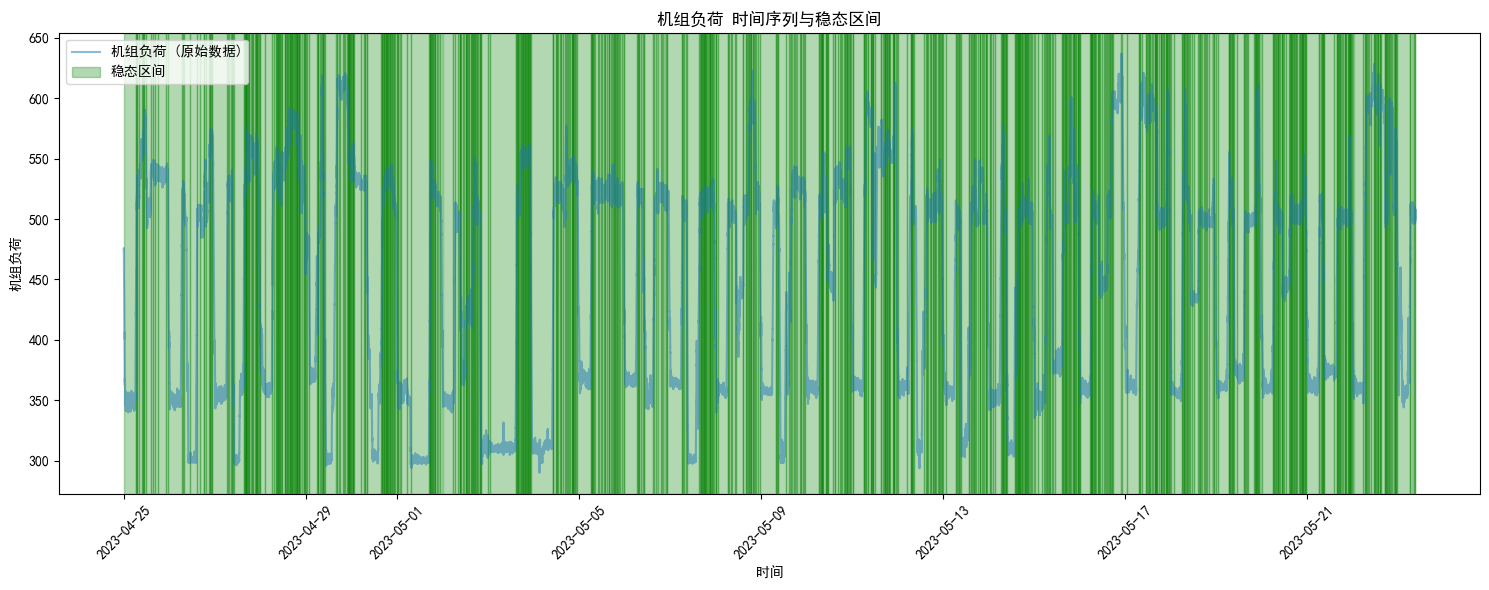

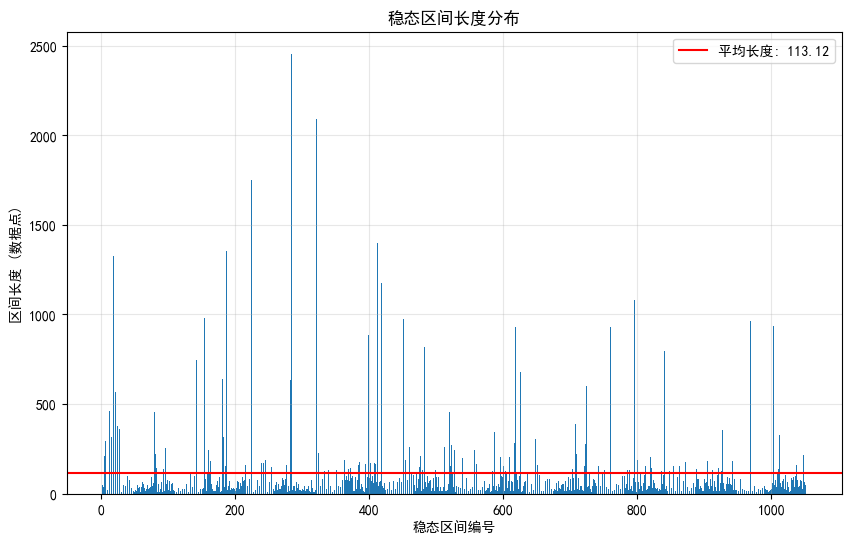

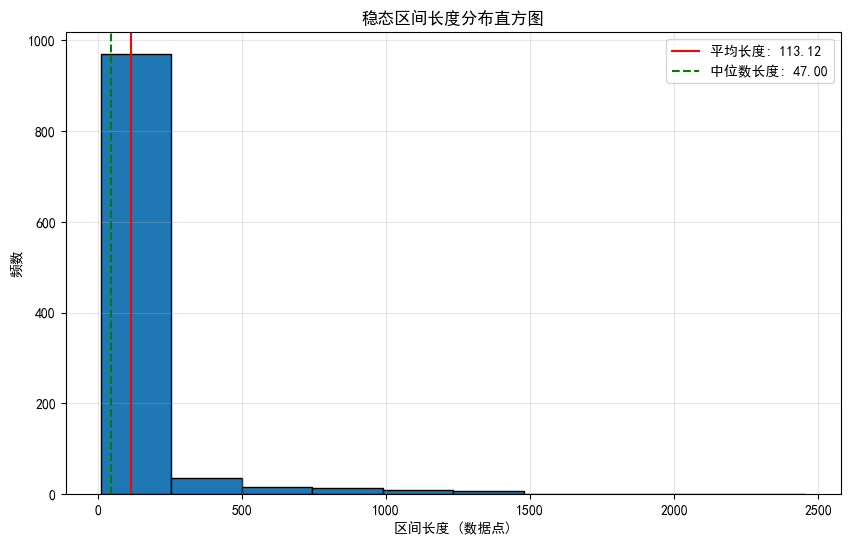

稳态数据已保存至：/content/drive/My Drive/steady_state_data.csv

稳态数据预览：
                      时间    机组负荷  汽轮机热耗率q  修正后热耗率q    修正系数   高压缸效率   中压缸效率  \
128 2023-04-25 00:42:00  346.45   8561.5   8779.2  0.9752  87.007  93.701   
129 2023-04-25 00:43:00  346.29   8679.1   8895.3  0.9757  87.081  93.757   
130 2023-04-25 00:43:00  347.37   8519.4   8735.2  0.9753  87.151  93.640   
131 2023-04-25 00:43:00  347.54   8682.4   8901.4  0.9754  87.325  93.483   
132 2023-04-25 00:44:00  347.27   8773.7   8996.8  0.9752  87.478  93.251   

     低压缸排汽压力  主给水流量c     Dms  ...  给泵出口母管压力  锅炉效率  除氧器下水温度1  除氧器下水温度2  \
128     3.54   995.4   993.1  ...     18.77   NaN    154.73    154.29   
129     3.54  1009.2  1006.9  ...     18.73   NaN    154.70    154.29   
130     3.54   992.8   990.5  ...     18.70   NaN    154.54    154.12   
131     3.53  1013.0  1010.7  ...     18.65   NaN    154.38    153.96   
132     3.53  1023.0  1020.6  ...     18.59   NaN    154.22    153.96   

     除氧器进水温度  除氧器进汽温度  高压缸排汽压力  高

In [ ]:
def detect_steady_state(df, column_name='机组负荷', window_size=30, std_threshold=5.0, min_duration=10):
    """检测稳态运行区间"""
    data = df[column_name].dropna()
    if len(data) == 0:
        print(f"列 '{column_name}' 无有效数据，跳过检测")
        return []

    smoothed_data = savgol_filter(data, window_length=window_size, polyorder=2)
    rolling_std = data.rolling(window=window_size, center=True).std()
    is_steady = rolling_std < std_threshold

    steady_intervals = []
    start_idx = None

    for i in range(len(is_steady)):
        if is_steady.iloc[i] and start_idx is None:
            start_idx = i
        elif not is_steady.iloc[i] and start_idx is not None:
            end_idx = i - 1
            if (end_idx - start_idx + 1) >= min_duration:
                steady_intervals.append((start_idx, end_idx))
            start_idx = None

    if start_idx is not None and (len(data) - start_idx) >= min_duration:
        steady_intervals.append((start_idx, len(data) - 1))

    total_length = len(data)
    steady_length = sum(end - start + 1 for start, end in steady_intervals)
    coverage = steady_length / total_length * 100
    stability = [data.iloc[start:end+1].std() for start, end in steady_intervals]

    # 计算每个稳态区间的长度
    interval_lengths = [end - start + 1 for start, end in steady_intervals]

    print(f"检测到 {len(steady_intervals)} 个稳态运行区间")
    print(f"稳态覆盖率: {coverage:.2f}%")
    print(f"各稳态区间标准差: {[f'{s:.2f}' for s in stability]}")
    print(f"各稳态区间长度: {interval_lengths} 数据点")
    print(f"最短稳态区间: {min(interval_lengths) if interval_lengths else 0} 数据点")
    print(f"最长稳态区间: {max(interval_lengths) if interval_lengths else 0} 数据点")
    print(f"平均稳态区间长度: {np.mean(interval_lengths):.2f} 数据点")

    for idx, (start, end) in enumerate(steady_intervals):
        start_time = df['时间'].iloc[start]
        end_time = df['时间'].iloc[end]
        avg_load = data.iloc[start:end+1].mean()
        duration = end - start + 1
        print(f"区间 {idx+1}: {start_time} 至 {end_time}, 平均负荷: {avg_load:.2f}, 长度: {duration} 数据点")

    return steady_intervals

def detect_steady_state_threshold(df, column_name='机组负荷', threshold=5.0, min_duration=10):
    """基于固定阈值的稳态检测（对比方法）"""
    data = df[column_name].dropna()
    diff = data.diff().abs()
    is_steady = diff < threshold

    steady_intervals = []
    start_idx = None

    for i in range(len(is_steady)):
        if is_steady.iloc[i] and start_idx is None:
            start_idx = i
        elif not is_steady.iloc[i] and start_idx is not None:
            end_idx = i - 1
            if (end_idx - start_idx + 1) >= min_duration:
                steady_intervals.append((start_idx, end_idx))
            start_idx = None

    if start_idx is not None and (len(data) - start_idx) >= min_duration:
        steady_intervals.append((start_idx, len(data) - 1))

    # 计算每个稳态区间的长度
    interval_lengths = [end - start + 1 for start, end in steady_intervals]

    print(f"[固定阈值法] 检测到 {len(steady_intervals)} 个稳态运行区间")
    print(f"[固定阈值法] 各稳态区间长度: {interval_lengths} 数据点")
    print(f"[固定阈值法] 最短稳态区间: {min(interval_lengths) if interval_lengths else 0} 数据点")
    print(f"[固定阈值法] 最长稳态区间: {max(interval_lengths) if interval_lengths else 0} 数据点")
    print(f"[固定阈值法] 平均稳态区间长度: {np.mean(interval_lengths):.2f} 数据点")

    return steady_intervals

def plot_steady_state(df, column_name='机组负荷', steady_intervals=None):
    """绘制时间序列与稳态区间"""
    data = df[column_name].dropna()
    time = pd.to_datetime(df['时间'])

    plt.figure(figsize=(15, 6))
    plt.plot(time, data, label=f'{column_name} (原始数据)', alpha=0.5)

    if steady_intervals:
        for start, end in steady_intervals:
            plt.axvspan(time.iloc[start], time.iloc[end], color='green', alpha=0.3,
                        label='稳态区间' if start == steady_intervals[0][0] else "")

    plt.title(f'{column_name} 时间序列与稳态区间')
    plt.xlabel('时间')
    plt.ylabel(column_name)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # 增加稳态区间长度分布可视化
    if steady_intervals:
        interval_lengths = [end - start + 1 for start, end in steady_intervals]
        plt.figure(figsize=(10, 6))
        plt.bar(range(1, len(interval_lengths) + 1), interval_lengths)
        plt.axhline(y=np.mean(interval_lengths), color='r', linestyle='-', label=f'平均长度: {np.mean(interval_lengths):.2f}')
        plt.xlabel('稳态区间编号')
        plt.ylabel('区间长度 (数据点)')
        plt.title('稳态区间长度分布')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

        # 绘制稳态区间长度的直方图
        plt.figure(figsize=(10, 6))
        plt.hist(interval_lengths, bins=10, edgecolor='black')
        plt.axvline(x=np.mean(interval_lengths), color='r', linestyle='-', label=f'平均长度: {np.mean(interval_lengths):.2f}')
        plt.axvline(x=np.median(interval_lengths), color='g', linestyle='--', label=f'中位数长度: {np.median(interval_lengths):.2f}')
        plt.xlabel('区间长度 (数据点)')
        plt.ylabel('频数')
        plt.title('稳态区间长度分布直方图')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

# 执行稳态检测
steady_intervals = detect_steady_state(df, column_name='机组负荷')
plot_steady_state(df, '机组负荷', steady_intervals)

# 合并相似的稳态区间
merged_steady_intervals = merge_similar_steady_intervals(df, steady_intervals, '机组负荷',
                                                        time_gap_threshold=5, load_diff_threshold=30)
# 对比实验：固定阈值法
steady_intervals_threshold = detect_steady_state_threshold(df, '机组负荷')
plot_steady_state(df, '机组负荷', steady_intervals_threshold)

# 保存稳态数据
steady_df = pd.DataFrame()
for idx, (start, end) in enumerate(merged_steady_intervals, 1):
    steady_segment = df.iloc[start:end+1].copy()
    steady_segment['稳态区间编号'] = idx
    steady_segment['稳态区间长度'] = end - start + 1  # 添加区间长度信息
    steady_df = pd.concat([steady_df, steady_segment])

steady_df.to_csv(STEADY_SAVE_PATH, index=False)
print(f"稳态数据已保存至：{STEADY_SAVE_PATH}")
print("\n稳态数据预览：\n", steady_df.head())

# 输出稳态区间长度的基本统计信息
if len(steady_intervals) > 0:
    interval_lengths = [end - start + 1 for start, end in steady_intervals]
    print("\n稳态区间长度统计信息:")
    print(f"数量: {len(interval_lengths)}")
    print(f"总和: {sum(interval_lengths)} 数据点")
    print(f"最小值: {min(interval_lengths)} 数据点")
    print(f"最大值: {max(interval_lengths)} 数据点")
    print(f"平均值: {np.mean(interval_lengths):.2f} 数据点")
    print(f"中位数: {np.median(interval_lengths):.2f} 数据点")
    print(f"标准差: {np.std(interval_lengths):.2f} 数据点")

## 特征提取与降维

稳态数据预览：
                     时间    机组负荷  汽轮机热耗率q  修正后热耗率q    修正系数   高压缸效率   中压缸效率  \
0  2023-04-25 00:42:00  346.45   8561.5   8779.2  0.9752  87.007  93.701   
1  2023-04-25 00:43:00  346.29   8679.1   8895.3  0.9757  87.081  93.757   
2  2023-04-25 00:43:00  347.37   8519.4   8735.2  0.9753  87.151  93.640   
3  2023-04-25 00:43:00  347.54   8682.4   8901.4  0.9754  87.325  93.483   
4  2023-04-25 00:44:00  347.27   8773.7   8996.8  0.9752  87.478  93.251   

   低压缸排汽压力  主给水流量c     Dms  ...  给泵出口母管压力  锅炉效率  除氧器下水温度1  除氧器下水温度2  除氧器进水温度  \
0     3.54   995.4   993.1  ...     18.77   NaN    154.73    154.29   120.58   
1     3.54  1009.2  1006.9  ...     18.73   NaN    154.70    154.29   120.41   
2     3.54   992.8   990.5  ...     18.70   NaN    154.54    154.12   120.41   
3     3.53  1013.0  1010.7  ...     18.65   NaN    154.38    153.96   120.24   
4     3.53  1023.0  1020.6  ...     18.59   NaN    154.22    153.96   120.08   

   除氧器进汽温度  高压缸排汽压力  高压缸排汽温度  稳态区间编号  稳态区间长度  
0   35

计算变异系数: 100%|██████████| 66/66 [00:00<00:00, 645.03it/s]


选择的特征：['凝结水补水流量', 'GV4阀位', '中压缸排汽压力', '二段抽汽压力', '再热汽压力', '一段抽汽压力', '高压缸排汽压力', '吹灰蒸汽压力', '主汽压力', 'GV1阀位']


填充数据: 100%|██████████| 367/367 [00:00<00:00, 70265.65it/s]


TS2Vec 输入数据形状： (367, 500, 10)
训练 TS2Vec 模型...
Epoch #0: loss=1451.6385493384466
Epoch #1: loss=87.08839276631673
Epoch #2: loss=37.295871024661594
Epoch #3: loss=35.640720743603175
Epoch #4: loss=20.140022145377266
Epoch #5: loss=14.234121735890707
Epoch #6: loss=13.323894193437365
Epoch #7: loss=11.786210674709745
Epoch #8: loss=9.889431858062744
Epoch #9: loss=9.081842719184028
Epoch #10: loss=7.196795527140299
Epoch #11: loss=7.413095039791531
Epoch #12: loss=7.102827925152249
Epoch #13: loss=6.677911636564467
Epoch #14: loss=7.685465706719293
Epoch #15: loss=7.597876988516914
Epoch #16: loss=5.430484082963732
Epoch #17: loss=5.313338094287449
Epoch #18: loss=5.18515763812595
Epoch #19: loss=4.776513301001655
Epoch #20: loss=4.2450269911024305
Epoch #21: loss=4.2615612930721705
Epoch #22: loss=3.898499912685818
Epoch #23: loss=3.744471459918552
Epoch #24: loss=3.80741311179267
Epoch #25: loss=4.662018118964301
Epoch #26: loss=4.093724377950033
Epoch #27: loss=6.320030286577013
Epoch

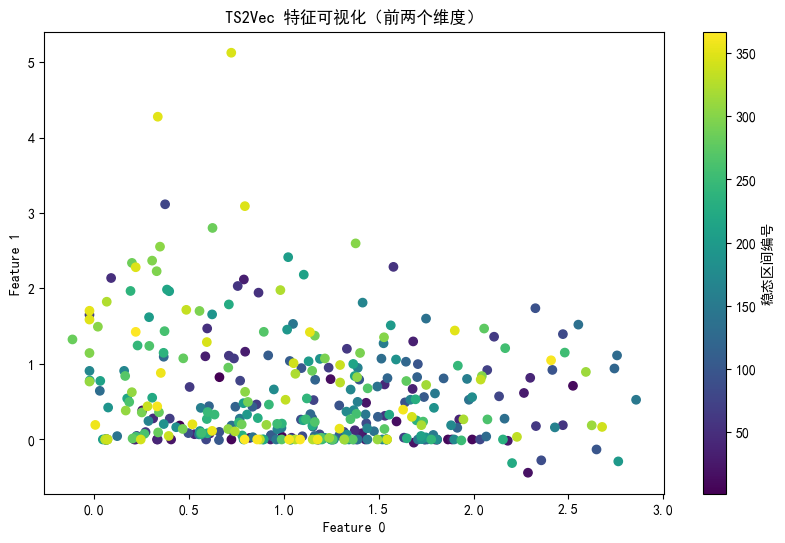

特征已保存至：/content/drive/My Drive/ts2vec_features.csv

特征数据预览：
    feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0   0.660514   0.824040   0.774627   1.278632   1.022729   0.908881   
1   0.451195   0.183844   0.335084   0.868743   1.502121   0.003932   
2   1.178990  -0.001236   0.053062   1.050479   1.686731   0.351927   
3   1.329330   0.046618   0.056054   1.153604   1.768118  -0.022825   
4   0.990426   0.035791   0.810605   1.023933   1.818724  -0.015011   

   feature_6  feature_7  feature_8  feature_9  ...  feature_55  feature_56  \
0   0.252449   0.935341   2.387017   0.008816  ...    0.680614    0.709417   
1   0.696257   0.019048   0.350755   0.158679  ...    0.366213    0.280557   
2   0.240659   1.309017   1.051882   0.400229  ...    0.637531    0.147165   
3   0.245816   0.019048   0.488355  -0.000072  ...    0.626657    0.147165   
4   0.346892   0.094368   0.150912   0.165125  ...   -0.058687    0.350756   

   feature_57  feature_58  feature_59  feat

In [ ]:
def calculate_cv(df, cols):
    """计算变异系数"""
    cv_dict = {}
    for col in tqdm(cols, desc="计算变异系数"):
        data = df[col].dropna()
        if len(data) > 0:
            cv_dict[col] = variation(data)
    return pd.DataFrame(list(cv_dict.items()), columns=['特征', '变异系数']).sort_values('变异系数', ascending=False)

def calculate_mutual_info(df, target_col, feature_cols):
    """计算互信息"""
    X = df[feature_cols].fillna(0)
    y = df[target_col].fillna(0)
    mi_scores = mutual_info_regression(X, y)
    return pd.DataFrame({'特征': feature_cols, '互信息': mi_scores}).sort_values('互信息', ascending=False)

def calculate_grey_relation(df, target_col, feature_cols):
    """计算灰色关联度"""
    X = df[feature_cols].fillna(0)
    y = df[target_col].fillna(0)
    X_norm = (X - X.min()) / (X.max() - X.min())
    y_norm = (y - y.min()) / (y.max() - y.min())
    diff = np.abs(X_norm.values - y_norm.values[:, None])
    rho = 0.5
    min_diff, max_diff = diff.min(), diff.max()
    grey_coeff = (min_diff + rho * max_diff) / (diff + rho * max_diff)
    grey_relation = grey_coeff.mean(axis=0)
    return pd.DataFrame({'特征': feature_cols, '灰色关联度': grey_relation}).sort_values('灰色关联度', ascending=False)

def prepare_ts2vec_data(df, feature_cols, group_col='稳态区间编号', max_len=500):
    """准备 TS2Vec 数据"""
    grouped = df.groupby(group_col)
    data_list = []

    for _, group in tqdm(grouped, desc="准备 TS2Vec 数据"):
        features = group[feature_cols].values
        if len(features) > max_len:
            indices = np.linspace(0, len(features) - 1, max_len).astype(int)
            features = features[indices]
        data_list.append(features)

    padded_data = np.zeros((len(data_list), max_len, len(feature_cols)))
    for i, seq in tqdm(enumerate(data_list), total=len(data_list), desc="填充数据"):
        padded_data[i, :len(seq), :] = seq
    return padded_data

# 加载稳态数据
steady_df = pd.read_csv(STEADY_SAVE_PATH)
print("稳态数据预览：\n", steady_df.head())

# 验证和修复稳态区间编号
num_steady_intervals = steady_df['稳态区间编号'].nunique()
if steady_df['稳态区间编号'].min() < 1 or steady_df['稳态区间编号'].max() != num_steady_intervals:
    print("修复稳态区间编号...")
    steady_df['稳态区间编号'] = steady_df.groupby('稳态区间编号').ngroup() + 1

# 特征选择
numeric_cols = steady_df.select_dtypes(include=[np.number]).columns.drop('稳态区间编号')
cv_df = calculate_cv(steady_df, numeric_cols)
target_col = '机组负荷'
mi_df = calculate_mutual_info(steady_df, target_col, numeric_cols.drop(target_col))
grey_df = calculate_grey_relation(steady_df, target_col, numeric_cols.drop(target_col))

must_include = ['主汽压力', '再热汽压力']
feature_cols = list(set(cv_df['特征'].head(4).tolist() + mi_df['特征'].head(4).tolist() +
                        grey_df['特征'].head(4).tolist() + must_include))
print(f"选择的特征：{feature_cols}")

# 准备 TS2Vec 数据
ts2vec_data = prepare_ts2vec_data(steady_df, feature_cols)
print("TS2Vec 输入数据形状：", ts2vec_data.shape)

# 训练 TS2Vec 模型
model = TS2Vec(input_dims=len(feature_cols), device='cpu', output_dims=64, hidden_dims=32, depth=5, batch_size=8, lr=0.001)
print("训练 TS2Vec 模型...")
model.fit(ts2vec_data, n_epochs=50, verbose=True)

# 特征提取
features = model.encode(ts2vec_data, encoding_window='full_series')
feature_df = pd.DataFrame(features, columns=[f'feature_{i}' for i in range(features.shape[1])])
feature_df['稳态区间编号'] = np.arange(1, len(feature_df) + 1)

# 可视化
plt.figure(figsize=(10, 6))
plt.scatter(feature_df['feature_0'], feature_df['feature_1'], c=feature_df['稳态区间编号'], cmap='viridis')
plt.title('TS2Vec 特征可视化（前两个维度）')
plt.xlabel('Feature 0')
plt.ylabel('Feature 1')
plt.colorbar(label='稳态区间编号')
plt.show()

# 保存特征
feature_df.to_csv(FEATURE_SAVE_PATH, index=False)
print(f"特征已保存至：{FEATURE_SAVE_PATH}")
print("\n特征数据预览：\n", feature_df.head())

## 聚类分析

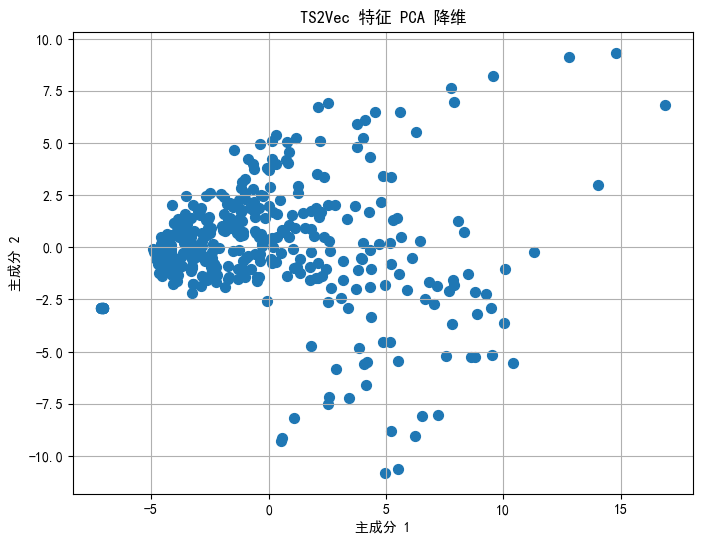

前两个主成分解释的方差比例：0.415
簇数 2 的轮廓系数：0.266
簇数 3 的轮廓系数：0.266
簇数 4 的轮廓系数：0.144
簇数 5 的轮廓系数：0.133
簇数 6 的轮廓系数：0.125
簇数 7 的轮廓系数：0.157
簇数 8 的轮廓系数：0.188
簇数 9 的轮廓系数：0.165
DBSCAN 检测到的簇数：2
噪声点数量：343


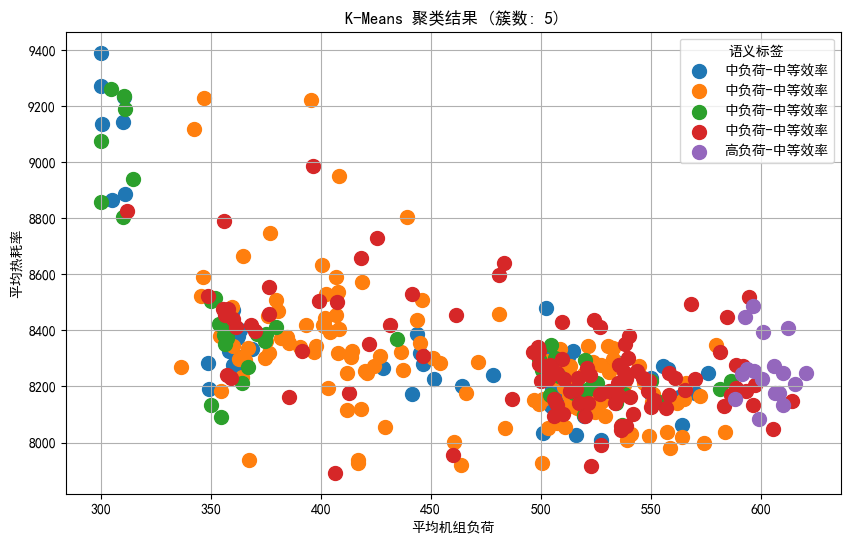

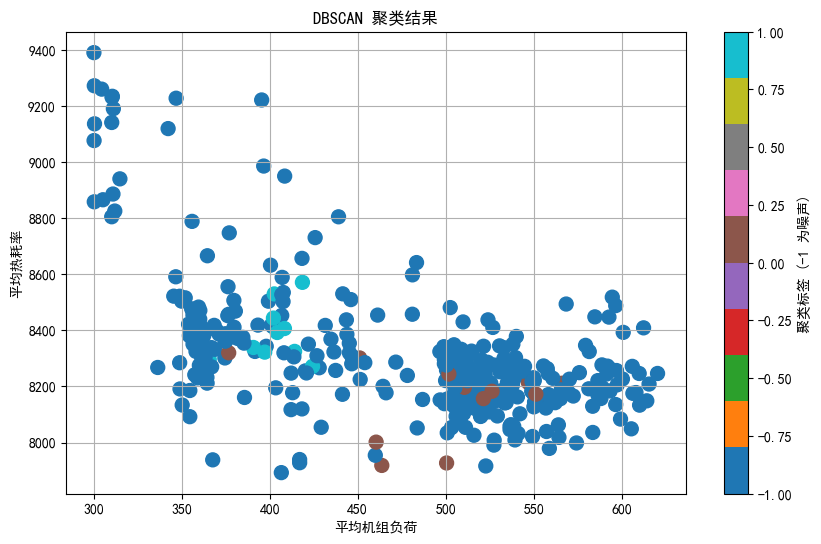

聚类结果已保存至：/content/drive/My Drive/clustering_data.csv

K-Means 聚类统计：
 Cluster_KMeans
0    132
4    106
3     65
1     47
2     17
Name: count, dtype: int64

K-Means 特征统计：
                     平均机组负荷                   平均热耗率            
                      mean        std         mean         std
Cluster_KMeans                                                
0               459.025039  70.201728  8290.678980  226.636296
1               435.291916  93.773262  8384.666664  309.008363
2               602.874408   9.125392  8260.253753  112.628316
3               455.789449  85.880379  8335.088398  301.304388
4               495.143446  75.593023  8284.593407  187.932523

DBSCAN 聚类统计：
 Cluster_DBSCAN
-1    343
 0     14
 1     10
Name: count, dtype: int64


In [ ]:
def assign_semantic_labels(df, cluster_col='Cluster_KMeans'):
    """分配语义标签"""
    cluster_stats = df.groupby(cluster_col).agg({
        '平均机组负荷': 'mean',
        '平均热耗率': 'mean'
    })
    load_mean, load_std = steady_grouped['平均机组负荷'].mean(), steady_grouped['平均机组负荷'].std()
    heat_mean, heat_std = steady_grouped['平均热耗率'].mean(), steady_grouped['平均热耗率'].std()
    labels = []
    for idx, row in cluster_stats.iterrows():
        load = row['平均机组负荷']
        heat = row['平均热耗率']
        load_label = ('高负荷' if load > load_mean + load_std else
                      '低负荷' if load < load_mean - load_std else '中负荷')
        heat_label = ('高效' if heat < heat_mean - heat_std else
                      '低效' if heat > heat_mean + heat_std else '中等效率')
        labels.append(f'{load_label}-{heat_label}')
    return df[cluster_col].map(dict(zip(cluster_stats.index, labels)))

# 加载数据
feature_df = pd.read_csv(FEATURE_SAVE_PATH)
steady_grouped = steady_df.groupby('稳态区间编号').agg({
    '机组负荷': 'mean',
    '汽轮机热耗率q': 'mean'
}).reset_index().rename(columns={'机组负荷': '平均机组负荷', '汽轮机热耗率q': '平均热耗率'})

# 准备特征
X = feature_df.drop(columns=['稳态区间编号']).values
X_scaled = StandardScaler().fit_transform(X)

# PCA 可视化
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=50)
plt.title('TS2Vec 特征 PCA 降维')
plt.xlabel('主成分 1')
plt.ylabel('主成分 2')
plt.grid(True)
plt.show()
print(f"前两个主成分解释的方差比例：{pca.explained_variance_ratio_.sum():.3f}")

# K-Means 聚类
silhouette_scores = [silhouette_score(X_scaled, KMeans(n_clusters=k, random_state=42).fit_predict(X_scaled))
                     for k in range(2, 10)]
for k, score in enumerate(silhouette_scores, 2):
    print(f"簇数 {k} 的轮廓系数：{score:.3f}")

n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
feature_df['Cluster_KMeans'] = kmeans.fit_predict(X_scaled)

# DBSCAN 聚类
dbscan = DBSCAN(eps=2.0, min_samples=5)
feature_df['Cluster_DBSCAN'] = dbscan.fit_predict(X_scaled)
n_clusters_dbscan = len(set(feature_df['Cluster_DBSCAN'])) - (1 if -1 in feature_df['Cluster_DBSCAN'].values else 0)
print(f"DBSCAN 检测到的簇数：{n_clusters_dbscan}")
print(f"噪声点数量：{(feature_df['Cluster_DBSCAN'] == -1).sum()}")

# 合并结果
clustered_df = steady_grouped.merge(feature_df[['稳态区间编号', 'Cluster_KMeans', 'Cluster_DBSCAN']],
                                   on='稳态区间编号', how='left').dropna(subset=['Cluster_KMeans'])
clustered_df['Semantic_Label'] = assign_semantic_labels(clustered_df)

# 可视化 K-Means
plt.figure(figsize=(10, 6))
for cluster_id in clustered_df['Cluster_KMeans'].unique():
    cluster_data = clustered_df[clustered_df['Cluster_KMeans'] == cluster_id]
    plt.scatter(cluster_data['平均机组负荷'], cluster_data['平均热耗率'],
                label=cluster_data['Semantic_Label'].iloc[0], s=100)
plt.title(f'K-Means 聚类结果 (簇数: {n_clusters})')
plt.xlabel('平均机组负荷')
plt.ylabel('平均热耗率')
plt.legend(title='语义标签')
plt.grid(True)
plt.show()

# 可视化 DBSCAN
plt.figure(figsize=(10, 6))
plt.scatter(clustered_df['平均机组负荷'], clustered_df['平均热耗率'],
            c=clustered_df['Cluster_DBSCAN'], cmap='tab10', s=100)
plt.title('DBSCAN 聚类结果')
plt.xlabel('平均机组负荷')
plt.ylabel('平均热耗率')
plt.colorbar(label='聚类标签 (-1 为噪声)')
plt.grid(True)
plt.show()

# 保存结果
clustered_df.to_csv(CLUSTER_SAVE_PATH, index=False)
print(f"聚类结果已保存至：{CLUSTER_SAVE_PATH}")

# 输出统计
print("\nK-Means 聚类统计：\n", clustered_df['Cluster_KMeans'].value_counts())
print("\nK-Means 特征统计：\n", clustered_df.groupby('Cluster_KMeans').agg({
    '平均机组负荷': ['mean', 'std'],
    '平均热耗率': ['mean', 'std']
}))
print("\nDBSCAN 聚类统计：\n", clustered_df['Cluster_DBSCAN'].value_counts())

准备聚类数据...
处理缺失值...

缺失值统计：
平均机组负荷    0
平均热耗率     1
主汽压力      2
主蒸汽流量     0
再热汽压力     0
高压缸效率     0
中压缸效率     1
锅炉效率      1
dtype: int64

填充后的缺失值统计：
平均机组负荷    0
平均热耗率     0
主汽压力      0
主蒸汽流量     0
再热汽压力     0
高压缸效率     0
中压缸效率     0
锅炉效率      0
dtype: int64

数据标准化...
确定最佳聚类数...


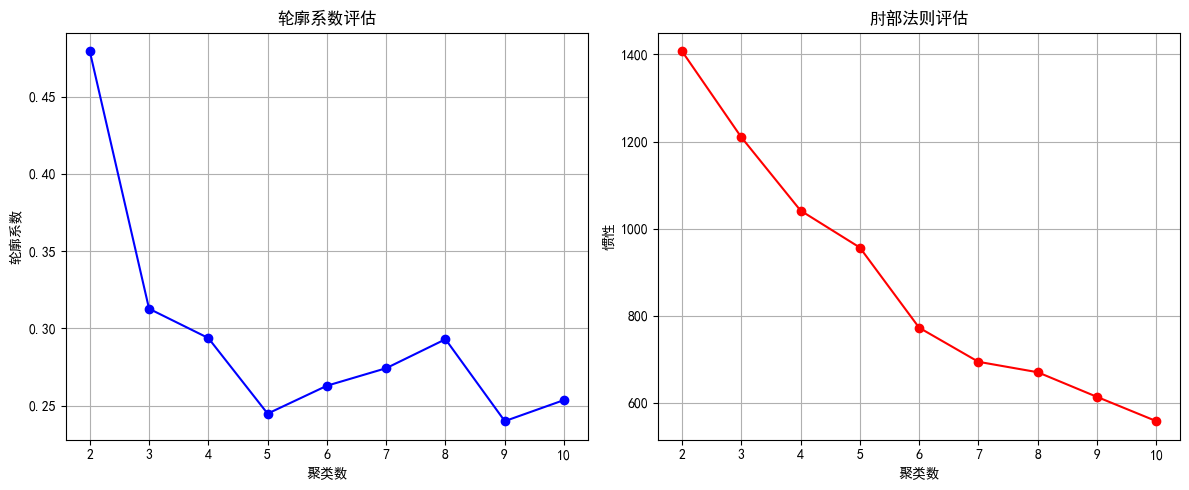


使用 5 个聚类进行分析...

聚类结果统计：

各聚类特征统计：
        平均机组负荷                   平均热耗率           主汽压力    主蒸汽流量  高压缸效率  中压缸效率  \
         count    mean    std     mean     std   mean     mean   mean   mean   
Cluster                                                                        
0           35  402.98  30.36  8550.91  238.40  18.62  1041.35  88.68  94.12   
1           64  495.06  36.12  8218.26  121.98  22.50  1279.28  87.79  94.80   
2          115  520.65  18.51  8200.70  105.35  23.37  1343.90  89.11  94.66   
3           98  364.01  32.68  8454.51  318.41  17.35   929.17  86.80  95.05   
4           55  583.18  20.28  8216.80  124.28  24.15  1549.42  91.27  94.59   

          锅炉效率     语义标签  
          mean <lambda>  
Cluster                  
0        93.38  中低负荷-低效  
1        94.26  中低负荷-中效  
2        93.81   中负荷-中效  
3        93.55   低负荷-低效  
4        94.07   中负荷-中效  


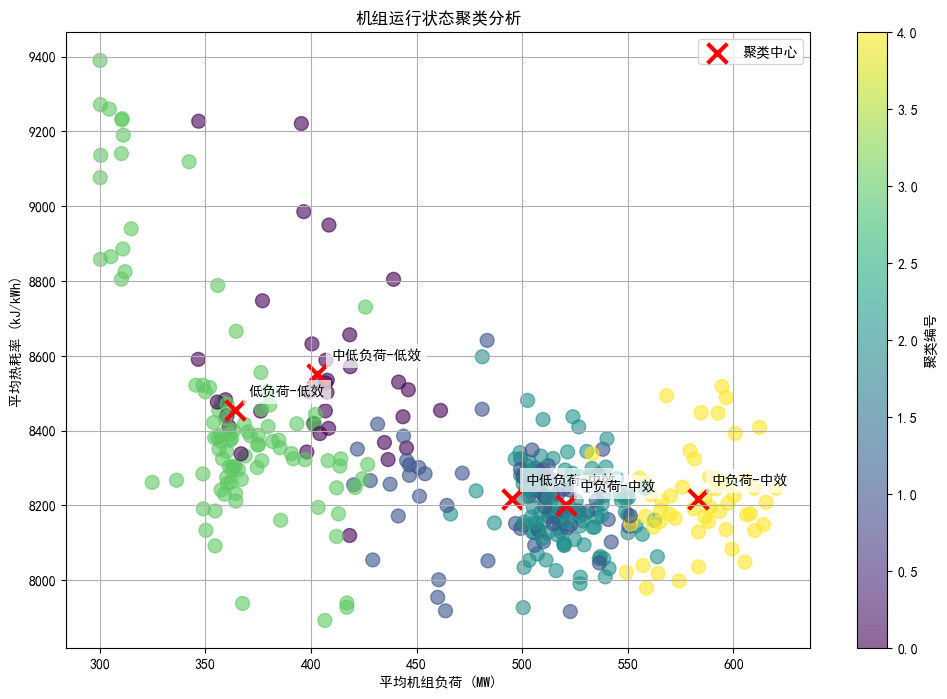


保存聚类结果...
聚类结果已保存至：/content/drive/My Drive/clustering_data.csv


In [ ]:
def assign_semantic_labels(df, cluster_col='Cluster'):
    """基于机组负荷和热耗率为聚类结果分配语义标签"""
    cluster_stats = df.groupby(cluster_col).agg({
        '平均机组负荷': ['mean', 'std'],
        '平均热耗率': ['mean', 'std']
    })

    # 定义负荷区间
    load_ranges = {
        '低负荷': (0, 400),
        '中低负荷': (400, 500),
        '中负荷': (500, 600),
        '高负荷': (600, float('inf'))
    }

    # 计算全局热耗率统计
    global_heat_mean = df['平均热耗率'].mean()
    global_heat_std = df['平均热耗率'].std()

    labels = {}
    for cluster in cluster_stats.index:
        load = cluster_stats.loc[cluster, ('平均机组负荷', 'mean')]
        heat = cluster_stats.loc[cluster, ('平均热耗率', 'mean')]

        # 确定负荷区间
        load_label = None
        for name, (low, high) in load_ranges.items():
            if low <= load < high:
                load_label = name
                break

        # 确定效率水平
        if heat < global_heat_mean - 0.5 * global_heat_std:
            eff_label = '高效'
        elif heat > global_heat_mean + 0.5 * global_heat_std:
            eff_label = '低效'
        else:
            eff_label = '中效'

        labels[cluster] = f'{load_label}-{eff_label}'

    return df[cluster_col].map(labels)

# 准备聚类数据
print("准备聚类数据...")
steady_grouped = steady_df.groupby('稳态区间编号').agg({
    '机组负荷': 'mean',
    '汽轮机热耗率q': 'mean',
    '主汽压力': 'mean',
    '主蒸汽流量': 'mean',
    '再热汽压力': 'mean',
    '高压缸效率': 'mean',
    '中压缸效率': 'mean',
    '锅炉效率': 'mean'
}).rename(columns={
    '机组负荷': '平均机组负荷',
    '汽轮机热耗率q': '平均热耗率'
})

# 处理缺失值
print("处理缺失值...")
# 1. 显示每个特征的缺失值数量
print("\n缺失值统计：")
print(steady_grouped.isnull().sum())

# 2. 使用中位数填充缺失值
steady_grouped = steady_grouped.fillna(steady_grouped.median())

# 确保没有剩余的缺失值
print("\n填充后的缺失值统计：")
print(steady_grouped.isnull().sum())

# 数据标准化
print("\n数据标准化...")
scaler = StandardScaler()
features_for_clustering = ['平均机组负荷', '平均热耗率', '主汽压力', '主蒸汽流量',
                         '再热汽压力', '高压缸效率', '中压缸效率', '锅炉效率']
X = scaler.fit_transform(steady_grouped[features_for_clustering])

# 确定最佳聚类数
print("确定最佳聚类数...")
silhouette_scores = []
inertias = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)
    silhouette_scores.append(silhouette_score(X, labels))
    inertias.append(kmeans.inertia_)

# 可视化评估指标
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_range, silhouette_scores, 'bo-')
plt.title('轮廓系数评估')
plt.xlabel('聚类数')
plt.ylabel('轮廓系数')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(k_range, inertias, 'ro-')
plt.title('肘部法则评估')
plt.xlabel('聚类数')
plt.ylabel('惯性')
plt.grid(True)
plt.tight_layout()
plt.show()

# 执行K-Means聚类
optimal_k = 5  # 根据评估结果选择
print(f"\n使用 {optimal_k} 个聚类进行分析...")
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
steady_grouped['Cluster'] = kmeans.fit_predict(X)
steady_grouped['语义标签'] = assign_semantic_labels(steady_grouped)

# 分析聚类结果
print("\n聚类结果统计：")
cluster_stats = steady_grouped.groupby('Cluster').agg({
    '平均机组负荷': ['count', 'mean', 'std'],
    '平均热耗率': ['mean', 'std'],
    '主汽压力': 'mean',
    '主蒸汽流量': 'mean',
    '高压缸效率': 'mean',
    '中压缸效率': 'mean',
    '锅炉效率': 'mean',
    '语义标签': lambda x: x.iloc[0]
}).round(2)

print("\n各聚类特征统计：")
print(cluster_stats)

# 可视化聚类结果
plt.figure(figsize=(12, 8))

# 主图：负荷-热耗率散点图
scatter = plt.scatter(steady_grouped['平均机组负荷'],
                     steady_grouped['平均热耗率'],
                     c=steady_grouped['Cluster'],
                     cmap='viridis',
                     s=100,
                     alpha=0.6)

# 添加聚类中心
centers = kmeans.cluster_centers_
plt.scatter(scaler.inverse_transform(centers)[:, 0],
           scaler.inverse_transform(centers)[:, 1],
           c='red', marker='x', s=200, linewidths=3,
           label='聚类中心')

# 为每个聚类添加标签
for cluster in range(optimal_k):
    cluster_data = steady_grouped[steady_grouped['Cluster'] == cluster]
    center_x = cluster_data['平均机组负荷'].mean()
    center_y = cluster_data['平均热耗率'].mean()
    label = cluster_data['语义标签'].iloc[0]
    plt.annotate(label, (center_x, center_y),
                xytext=(10, 10), textcoords='offset points',
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))

plt.title('机组运行状态聚类分析')
plt.xlabel('平均机组负荷 (MW)')
plt.ylabel('平均热耗率 (kJ/kWh)')
plt.colorbar(scatter, label='聚类编号')
plt.grid(True)
plt.legend()
plt.show()

# 保存结果
print("\n保存聚类结果...")
steady_grouped.to_csv(CLUSTER_SAVE_PATH, index=False)
print(f"聚类结果已保存至：{CLUSTER_SAVE_PATH}")